In [1]:
## Time Series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

# Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin. 


In [2]:
# Get data

# We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin. 


import wget

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"
filename = wget.download(url)


In [3]:
# Importing time series with pandas

import pandas as pd 

df = pd.read_csv(filename,parse_dates=["Date"],index_col=["Date"]) 


In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
# How many samples we have

len(df)

2787

In [7]:
# We've collected the historical price of Bitcoin for the past 8 years but there's samples. 

# Typically deep learning models usually like lots and lots and lots of samples (where lots and
# lots and lots can thousands to tens of thousands to milions). 

# A smaller number of samples is something you'll often run into with time series data problems. 

# **Note**: The **seasonality** of a time series dataset is referred as the number of samples per year.
# So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect
# one sample per day meaning we'll get 365 samples per year. 



In [8]:
# Only want closing price for each day

bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


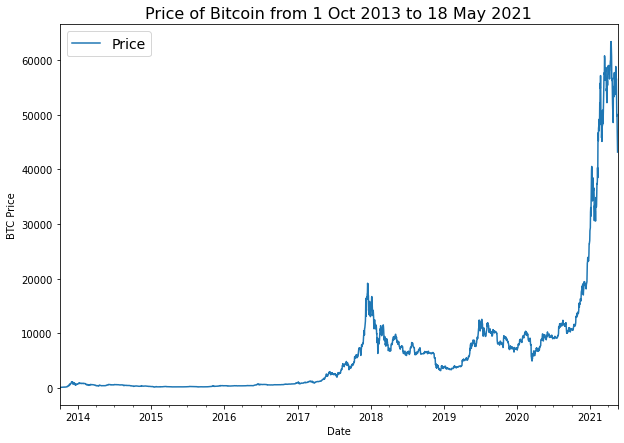

In [9]:
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

In [10]:
## Format data part 1: Create train and test sets of our time series data 

# Creating train and test sets with time series data (the wrong way)

# Get bitcoin data array

timesteps = bitcoin_prices.index.to_numpy()
prices    = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test sets for time series data

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
#                                                    prices,    # BTC prices
#                                                    test_size=0.2,
#                                                    random_state=42
#                                                    )

# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [12]:
# Let's plot wrong train and test splits

# plt.figure(figsize=(10,7))
# plt.scatter(X_train, y_train, s=5, label="Train data")
# plt.scatter(X_test, y_test, s=5, label="Test data")
# plt.xlabel("Date")
# plt.ylabel("BTC Price")
# plt.legend(fontsize=14)
# plt.show();

In [13]:
### Create train & test sets for time series (the right way)

# Create train and test splits the right way for time series data

split_size = int(0.8 * len(prices)) # 80% train, 20% test 

# Create train data splits (everything before the split)

X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

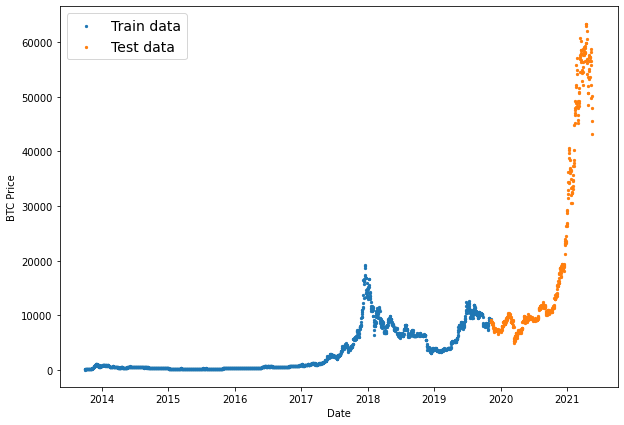

In [14]:
# Plot correctly made splits

plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

In [15]:
# Creating a plotting function

# Typing plotting code is tedious, let's functionize it. 

# Create a function to plot time series data

def plot_time_series(timesteps, values, format=".",start=0,end=None, label=None):

    """"
    Plots timesteps (a series of points in time) against values (a series of values across timesteps).

    Parameters
    ----------
    timesteps : array of timestep values
    values    : array of values across time
    format    : style of plot, default "."
    start     : where to start the plot (setting a value will index from start of timesteps & values)
    end       : where to end the plot (similar to start but for the end)
    label     : label to show on plot about values, default None
    
    """

    # Plot the series
    
    
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")

    if label:
        
        plt.legend(fontsize=14)
    plt.grid(True)

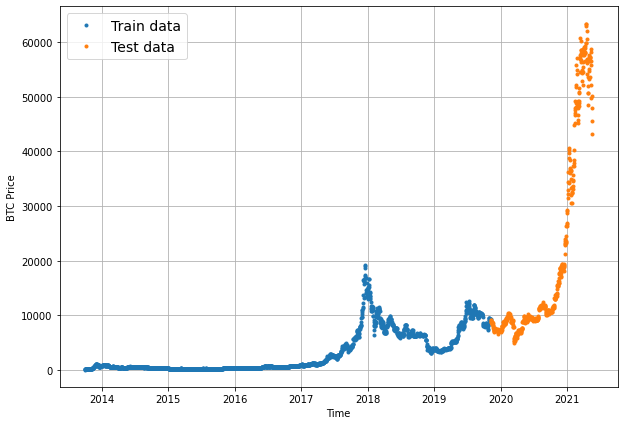

In [16]:
# Test out plottin function

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [17]:
## Modelling Experiments

# We've got some Bitcoin historical data, to model it, let's run a series of modelling 
# experiments and see which model performs best. 


# Terms to be familiar with:

# * Horizon     = number of timesteps into the future we're going to predict
# * Window size = number of timesteps we're going to use to predict horizon

# Modelling experiments we're running:

# * 0.  Naive model (baseline)
# * 1.  Dense model 1, horizon = 1, window = 7
# * 2.  Same as 1,     horizon = 1, window = 30
# * 3.  Same as 1,     horizon = 7, window = 30
# * 4.  Conv1D
# * 5.  LSTM
# * 6.  Same as 1 (nut with multivariate data)
# * 7.  N-BEATs Algorithm
# * 8.  Ensemble (multiple models optimized on different loss functions)
# * 9.  Future prediction model (model to predict future values)
# * 10. Same as 1 (but with turkey data introduced)

In [18]:
## Model 0: Naive forecast (baseline)

# The formula looks like this:
# $$\hat{y}_{t} = y_{t-1}$$

# In English:

# The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1. 

# Create a naive forecast 

naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [19]:
y_test[-10:]

array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
       52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
       45604.61575361, 43144.47129086])

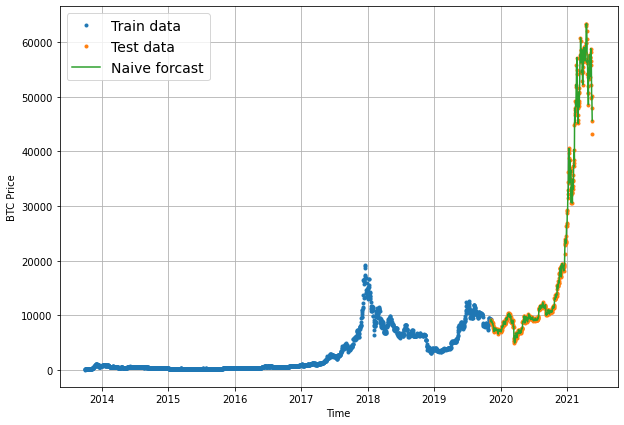

In [20]:
# Plot naive forecast

plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",label="Naive forcast")

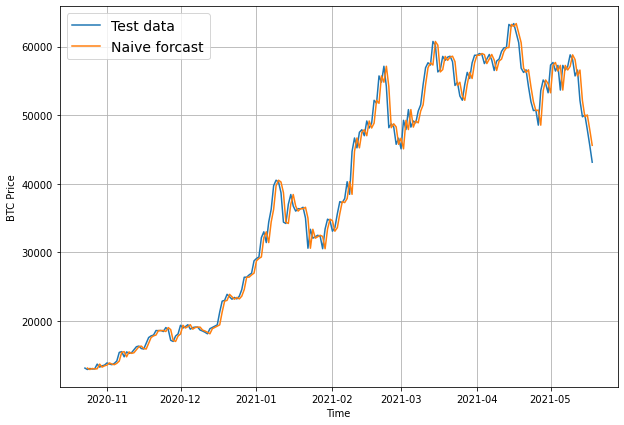

In [21]:
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_test, values=y_test,format="-",start=350, label="Test data")
plot_time_series(timesteps=X_test[1:],values=naive_forecast,format="-",start=350,label="Naive forcast")

In [22]:
## Evaluating a time series model

# Let's look into some evaluation metrics for time series forecasting. 

# What are we doing?

# We're predicting a number, so that means we have a form of a regression problem. 

# Because we're working on a regression problem, we'll need some regression-like metrics. 

# A few common regression metrics (which can also be used for time series forecasting):

# * MAE         - mean absolute error
# * MSE         - mean squared error
# * RMSE        - root mean square error
# * MAPE/ sMAPE - (symmetric) mean absolute percentage error
# * MASE        - mean absolute scaled error


# For all of the above metrics, **lower is better**, for example, an MAE of 0 that 
# is better than an MAE of 100. 

# The main thing we're evaluating here is: how do our model's forecasts (y_pred) compare 
# against the actual values (y_true or ground truth values)? 


In [23]:
import tensorflow as tf

In [24]:
# MASE implementation 

def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).

    """

    mae = tf.reduce_mean(tf.abs(y_true-y_pred))

    # Find MAE of naive forecast (no seasonality)

    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

    return mae / mae_naive_no_season


In [25]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [26]:
y_test[0].dtype

dtype('float64')

In [27]:
# Create a function to take in model predictions and truth values and return evaluation metrics

def evaluate_preds(y_true, y_pred):
    
    # Make sure float32 datatype (for metric calculations)

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics

    mae  = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse  = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    return {
        "mae" : mae.numpy(),
        "mse" : mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
        }


In [28]:
# That's one good looking evaluation function! Let's now see if it works... 

naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [29]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [30]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [31]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

In [32]:
## Other models you can use for baselines and for actual forecasts

# In this notebook, we're focused on TensorFlow and deep learning models. 

# However there are plenty of other styles of time series forecasting models you may want to experiment with:

# https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts



In [33]:
## Format Data Part 2: Windowing our dataset

# Why do we window?

# We window our time series dataset to turn our data into supervised learning problem. 

# ''' 
# Windowing for one week
# [0, 1, 2, 3, 4, 5, 6] -> [7]
# [1, 2, 3, 4, 5, 6, 7] -> [8]
# [1, 2, 3, 4, 6, 7, 8] -> [9]
# '''  


In [34]:
len(y_train)

2229

In [35]:
prices[:7], prices[7]

(array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  ]),
 123.033)

In [36]:
# What we want to do with our Bitcoin data

print(f"We want to use: {prices[:7]} to predict this: {prices[7]}")

We want to use: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] to predict this: 123.033


In [37]:
# Let's setup global variables for window and horizon size

HORIZON = 1     # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make the prediction



In [38]:
# Create function to label windowed data

def get_labelled_windows(x, horizon=HORIZON):
    """  
    Creates labels for windowed dataset.

    E.g. if horizon = 1
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
    """

    return x[:, :-horizon], x[:, -horizon:]
    

In [39]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [40]:
# We've got a way to label our windowed data. 
# However, this onlu works on a small scale. 
# We need a way to do the above across our entire time series. 

# We could do this with Python for loops, however, for large time series, that'd be quite slow. 
# To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html.


# Our function will:

# 1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
# 2. Usu NumPy indexing to create a 2D array of multiple window steps, for example:
"""  
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]

"""
# 3. Uses the 2D array of multiple window steps (from 2.) to index on a target series(e.g.
#    the historical price of Bitcoin)
# 4. Uses our 'get_labelled_windows()' function we created above to turn the window steps 
#    into windows with specified horizon. 



'  \n[[0, 1, 2, 3, 4, 5, 6],\n[1, 2, 3, 4, 5, 6, 7],\n[2, 3, 4, 5, 6, 7, 8]]\n\n'

In [41]:
import numpy as np

In [42]:
# Create function to view NumPy arrays as windows

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """  
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.

    """

    # 1. Create a window of specifin window_size (add the horizon on the end for labelling later)

    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

    # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)

    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)),axis=0).T # create 2D array of windows of size window_size
    # print(f"Window indexes:\n {window_indexes, window_indexes.shape}")

    # 3. Index on the target array (a time series) with 2D array of multiple window steps

    windowed_array = x[window_indexes]
    # print(windowed_array)

    # 4. Get the labelled windows

    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

    return windows, labels 


In [43]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE,horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [44]:
# View the first 3 windows/labels 

for i in range(3):
    print(f"Window: {full_windows[i]} -> Label {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label [125.96116]


In [45]:
# View the last 3 windows/labels 

for i in range(3):
    print(f"Window: {full_windows[i-3]} -> Label {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label [43144.47129086]


In [46]:
### **Note** There's a function which does similar to the above in tf.keras.preprocessing, an extension could be to try and
# replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array



In [47]:
# Turning windows into training and test sets

def make_train_test_splits(windows, labels, test_split=0.2):
    """  
    Splits matching pairs of windows and labels into train and test splits.
    """

    split_size = int(len(windows) * (1-test_split)) # this will default to 80% train / 20% test dataset
    train_windows = windows[:split_size]
    train_labels  = labels[:split_size]
    test_windows  = windows[split_size:]
    test_labels   = labels[split_size:] 

    return train_windows, test_windows, train_labels, test_labels

In [48]:
# Create train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [49]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [50]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [51]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

In [52]:
## Make a modelling checkpoint callback

# Because our model's performance will fluctuate from experiment to experiment, we're 
# going to write a model checkpoint se we can compare apples to apples. 

# More specifically, we want to compare each of our model's best performances against
# the other model's best performances. 

# For example if our model performs the best on epoch 55 (but we're training for 100 epochs),
# we want to load and evaluate the model saved on epoch 55. 



In [53]:
import os 

# Create a function to impement a ModelCheckpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name),
                                                                    verbose=0,
                                                                    save_best_only=True)

In [54]:
## Model 1: Dense model (window =7, horizon = 1)

# Our first deep model is going to be a simple dense model:

# * A single dense layer with 128 hidden units and ReLU
# * An output layer with linear activation (no activation)
# * Adam optimizer and MAE loss function
# * Batch size of 128 (previously we've used 32)
# * 100 epochs



In [55]:
import tensorflow as tf

# Set random seed for as reproducible results as possible

tf.random.set_seed(42)

# 1. Construct model

model_1 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON, activation="linear") # Linear activation is the same as having no activation
],name="model_1_dense")

model_1.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"]
)

history_model_1 = model_1.fit(
    train_windows,
    train_labels,
    epochs=100,
    
    validation_data = (test_windows, test_labels),
    verbose=1,
    batch_size=128,
    
    callbacks = [create_model_checkpoint(model_name=model_1.name)]
    )

Epoch 1/100
18/18 [==============================] - 3s 83ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 52ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 47ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.5938 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
Epoch 4/100
18/18 [==============================] - 1s 42ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.7500
Epoch 5/100
18/18 [==============================] - 1s 44ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.8125 - val_loss: 895.2236 - val_mae: 895.2236 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 44ms/step - loss: 158.5

In [56]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.9752 - mae: 585.9752 - mse: 1197801.2500


[585.9752197265625, 585.9752197265625, 1197801.25]

In [57]:
# Load in saved best performing model_1 and evaluate it on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.8750


[568.9510498046875, 568.9510498046875, 1171743.875]

In [58]:
# Making forecasts with a model (on the test dataset)

# To make "forecasts" on the test dataset (note: these won't be actual forecasts, they're 
# only psuedo forecasts because actual forecasts are into the future), let's write a function to:

# 1. Take in a train model
# 2. Takes in some input data (same kind of data the model was trained on)
# 3. Passes the input data to the model's predict() method
# 4. Returns the predictions 

In [59]:
def make_preds(model, input_data):
    """  
    Uses model to make predictions input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [60]:
# Make predictions using model_1 on the test dataset and view results 

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.713, 8769.888, 9015.712, 8795.52 , 8723.812, 8730.111,
        8691.953, 8502.056, 8460.962, 8516.548], dtype=float32)>)

In [61]:
tf.squeeze(test_labels).shape, model_1_preds.shape

(TensorShape([556]), TensorShape([556]))

In [62]:
# Evaluate preds 

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)

model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [63]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

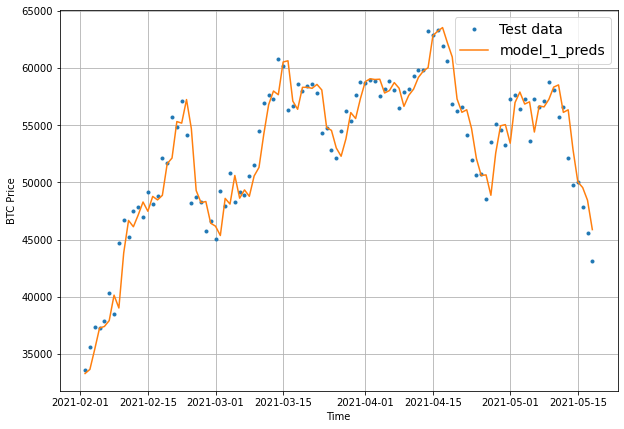

In [64]:
# Let's plot our model 1 predictions

offset = 450
plt.figure(figsize=(10,7))

# Account for the test_window offset and index into test_labels to ensure correct plotting

plot_time_series(
    timesteps=X_test[-len(test_windows): ], 
    values=test_labels[:, 0], 
    start=offset, 
    label="Test data")

plot_time_series(
    timesteps=X_test[-len(test_windows): ], 
    values=model_1_preds, 
    start=offset,
    format="-", 
    label="model_1_preds")


In [65]:
## Model 2: Dense (window = 30, horizon = 1)

HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [66]:
# Make windowed data with appropriate horizon and window sizes

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)

(2757, 2757)

In [67]:
# Make train and testing windows

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [68]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [69]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON,activation="linear")
],name="model_2_dense")

model_2.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"]
)

history_model_2 = model_2.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size = 128,
    verbose=0,
    validation_data=(test_windows,test_labels),
    callbacks = [create_model_checkpoint(model_name=model_2.name)]
)

INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_2_dense\assets
INFO:tensorflow:Assets written to: mod

In [70]:
# Evaluate model 2 on test data

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9620 - mae: 608.9620 - mse: 1281440.6250


[608.9619750976562, 608.9619750976562, 1281440.625]

In [71]:
# Load in the best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 608.9620 - mae: 608.9620 - mse: 1281440.6250


[608.9619750976562, 608.9619750976562, 1281440.625]

In [72]:
# Get forecast predictions

model_2_preds = make_preds(model_2,input_data=test_windows)


18/18 [==============================] - 0s 2ms/step


In [73]:
# Evaluate results for model 2 predictions 

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_2_preds)
model_2_results

{'mae': 608.962,
 'mse': 1281440.6,
 'rmse': 1132.0073,
 'mape': 2.769341,
 'mase': 1.0644715}

In [74]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

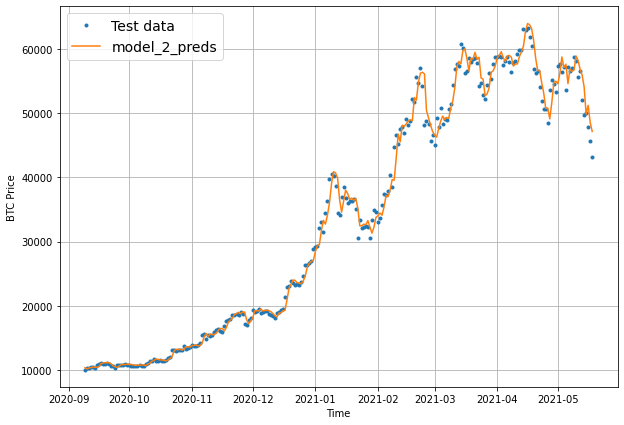

In [75]:
offset = 300
plt.figure(figsize=(10,7))
# Account for test_window offset when plotting
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_2_preds,start=offset,format="-",label="model_2_preds")

In [76]:
HORIZON = 7
WINDOW_SIZE = 30

In [77]:
full_windows, full_labels = make_windows(x=prices,window_size=WINDOW_SIZE,horizon=HORIZON)

In [78]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels,test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [79]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON,activation="linear")
],name="model_3_dense")

model_3.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics=["mse","mae"]
)

history_model_3 = model_3.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_3.name)],
    batch_size=128,
    verbose=0
)

INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: model_experiments\model_3_dense\assets
INFO:tensorflow:Assets written to: mod

In [80]:
model_3.evaluate(test_windows, test_labels)



18/18 [==============================] - 0s 3ms/step - loss: 1340.4272 - mse: 5758703.5000 - mae: 1340.4272


[1340.42724609375, 5758703.5, 1340.42724609375]

In [81]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 1234.8838 - mse: 5393733.5000 - mae: 1234.8838


[1234.8837890625, 5393733.5, 1234.8837890625]

In [82]:
model_3_preds = make_preds(model_3,test_windows)

18/18 [==============================] - 0s 2ms/step


In [83]:
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9250.798 , 9279.124 , 9394.038 , 9400.202 , 9479.183 , 9375.264 ,
        9302.472 ],
       [8945.557 , 9029.439 , 9164.761 , 8997.948 , 9077.654 , 8971.883 ,
        9081.854 ],
       [8883.711 , 8987.258 , 9057.07  , 8901.714 , 9001.872 , 8817.509 ,
        8971.558 ],
       [9090.947 , 9014.501 , 9010.567 , 9096.448 , 9052.973 , 9016.151 ,
        9001.476 ],
       [9002.045 , 8972.497 , 8869.7705, 8980.389 , 9212.569 , 9072.293 ,
        8887.335 ]], dtype=float32)>

In [84]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_3_preds)
model_3_results

{'mae': array([  561.22504 ,   301.9714  ,   297.9477  ,   413.84305 ,
          445.20914 ,   540.59717 ,   527.2284  ,   441.84564 ,
          498.77365 ,   639.19226 ,   803.132   ,   731.72614 ,
          678.6171  ,   797.18567 ,   575.334   ,   280.21136 ,
          239.92166 ,   246.152   ,   276.387   ,   285.75488 ,
          118.8042  ,   135.45549 ,   191.11852 ,   251.82582 ,
          170.28928 ,   154.20027 ,   107.244835,    97.66267 ,
          111.26409 ,   139.85393 ,   269.1739  ,   369.812   ,
          270.48096 ,   263.1211  ,   247.72252 ,   255.50523 ,
          298.48172 ,   245.26395 ,   243.13072 ,   255.7583  ,
          416.6257  ,   150.97021 ,    94.16581 ,   101.62012 ,
           93.76967 ,    86.753136,    73.2793  ,    79.045204,
           89.541084,    93.11977 ,   106.798546,   141.09578 ,
          178.73668 ,   145.46994 ,   256.4566  ,   392.8164  ,
          560.91174 ,   552.8188  ,   536.1548  ,   535.2687  ,
          448.70453 ,   267.23297

In [85]:
model_3_results["mae"].shape, model_3_results["mae"].ndim

((551,), 1)

In [86]:
model_2_results["mae"].shape, model_2_results["mae"].ndim

((), 0)

In [87]:
## Make our evaluation function work for larger horizons

def evaluate_preds(y_true, y_pred):
    
    # Make sure float32 datatype (for metric calculations)

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Calculate various evaluation metrics

    mae  = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse  = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = mean_absolute_scaled_error(y_true, y_pred)

    # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)

    if mae.ndim > 0:
        mae  = tf.reduce_mean(mae)
        mse  = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {
        "mae" : mae.numpy(),
        "mse" : mse.numpy(),
        "rmse": rmse.numpy(),
        "mape": mape.numpy(),
        "mase": mase.numpy()
        }


In [88]:
# Get model_3 results aggregated to single values 

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_3_preds)
model_3_results

{'mae': 1234.8838,
 'mse': 5393734.0,
 'rmse': 1419.1362,
 'mape': 5.4874983,
 'mase': 2.1974063}

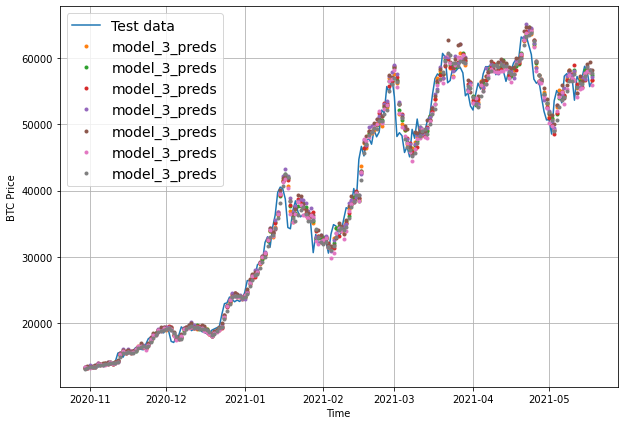

In [89]:
# We've made and evaluated predictions with model_3, let's visualize, visualize, visualize!

offset = 350
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],format="-",start=offset,label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],values=model_3_preds,start=offset,label="model_3_preds")

In [90]:
model_3_preds[0]

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([9250.798, 9279.124, 9394.038, 9400.202, 9479.183, 9375.264,
       9302.472], dtype=float32)>

In [91]:
tf.reduce_mean(model_3_preds[0])

<tf.Tensor: shape=(), dtype=float32, numpy=9354.44>

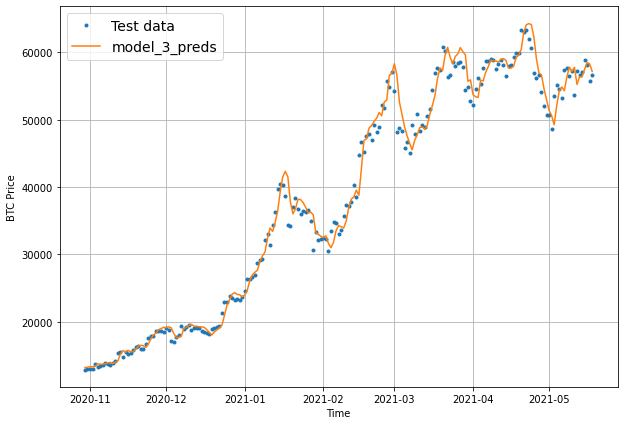

In [92]:
offset = 350
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:,0],start=offset,label="Test data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    format="-",
    values=tf.reduce_mean(model_3_preds,axis=1),
    start=offset,
    label="model_3_preds")

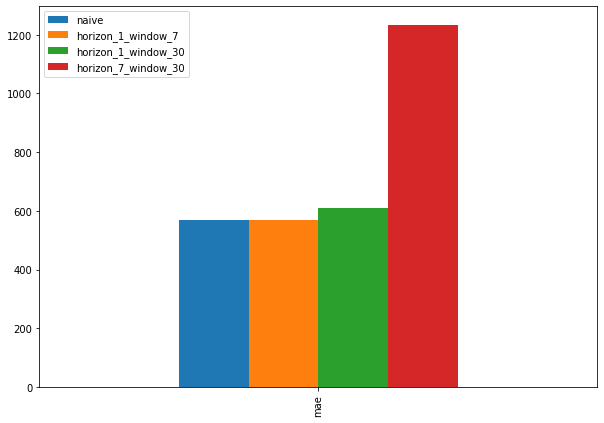

In [93]:
results = pd.DataFrame({
    "naive":naive_results["mae"],
    "horizon_1_window_7":model_1_results["mae"],
    "horizon_1_window_30":model_2_results["mae"],
    "horizon_7_window_30":model_3_results["mae"]},index=["mae"]).plot(figsize=(10,7),kind="bar");

In [94]:
## **Note** You might be wondering, why are the naive results so good? One of the reasons
# could be due the presence of autocorrelation in the data. If a time series has autocorrelation
# it means the value at t+1 (the next timestep) is typically close to the value at t (the current 
# timestep). In other words, today's value is probably pretty close to yesterday's value. Of course,
# this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate
# randomly), a naive model will often get fairly good results. 

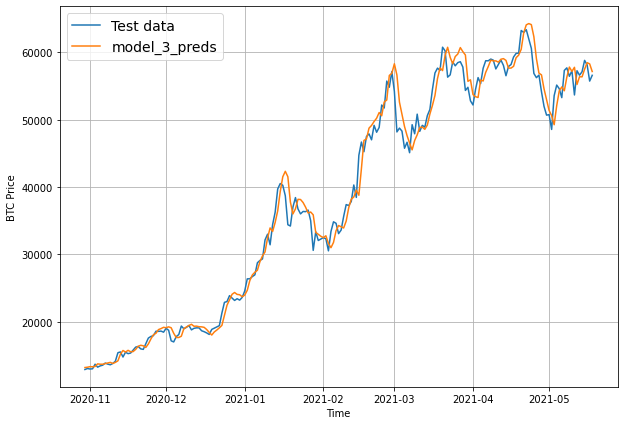

In [95]:
offset = 350
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    values=test_labels[:,0],
    start=offset,
    format="-", 
    label="Test data")
plot_time_series(
    timesteps=X_test[-len(test_windows):],
    format="-",
    values=tf.reduce_mean(model_3_preds,axis=1),
    start=offset,
    label="model_3_preds")

In [96]:
## Model 4: Conv1D 

In [97]:
HORIZON = 1
WINDOW_SIZE = 7 

full_windows, full_labels = make_windows(prices,WINDOW_SIZE,HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [98]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [99]:
# We need an input shape of: '(batch_size, timesteps, input_dim)' 
# However our data isn't in that shape yet

In [100]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [101]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works

x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [102]:
expand_dims_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for 'input_dim'  

In [103]:
# Test out our lambda layer

print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [104]:
# Create Conv1D 
# Lambda layer
# Conv1D model, filters=128, kernel_size=5, padding="same"
# Output layer = dense

In [105]:
tf.random.set_seed(42)

model_4 = tf.keras.Sequential([ 
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    tf.keras.layers.Conv1D(filters=128,kernel_size=7,strides=1,padding="causal",activation="relu"),
    tf.keras.layers.Dense(HORIZON,activation="linear")
],name="model_4_Conv1D")

model_4.compile(
    loss ="mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"]
)

history_model_4 = model_4.fit(
    train_windows,
    train_labels,
    epochs=100,
    validation_data=(test_windows, test_labels),
    batch_size=128,
    verbose=0,
    callbacks = [create_model_checkpoint(model_4.name)]
)

INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


INFO:tensorflow:Assets written to: model_experiments\model_4_Conv1D\assets


In [106]:
model_4.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 7ms/step - loss: 615.6102 - mae: 615.6102 - mse: 1267593.1250


[615.6101684570312, 615.6101684570312, 1267593.125]

In [107]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 570.7388 - mae: 570.7388 - mse: 1183500.2500


[570.7388305664062, 570.7388305664062, 1183500.25]

In [108]:
model_4_preds = model_4.predict(test_windows)
model_4_preds

18/18 [==============================] - 0s 2ms/step


array([[[ 8893.429 ]],

       [[ 8788.89  ]],

       [[ 9020.29  ]],

       [[ 8796.402 ]],

       [[ 8743.089 ]],

       [[ 8764.085 ]],

       [[ 8680.323 ]],

       [[ 8538.849 ]],

       [[ 8475.116 ]],

       [[ 8526.651 ]],

       [[ 8281.838 ]],

       [[ 8129.7383]],

       [[ 8084.4233]],

       [[ 7705.76  ]],

       [[ 7316.243 ]],

       [[ 7272.738 ]],

       [[ 7082.503 ]],

       [[ 7153.3833]],

       [[ 7158.25  ]],

       [[ 7440.8247]],

       [[ 7445.7637]],

       [[ 7667.9263]],

       [[ 7618.596 ]],

       [[ 7425.936 ]],

       [[ 7356.4277]],

       [[ 7321.4263]],

       [[ 7237.3955]],

       [[ 7358.21  ]],

       [[ 7500.9976]],

       [[ 7542.384 ]],

       [[ 7564.619 ]],

       [[ 7396.5522]],

       [[ 7264.6807]],

       [[ 7210.0703]],

       [[ 7190.4243]],

       [[ 7230.0376]],

       [[ 7125.3057]],

       [[ 7109.22  ]],

       [[ 6940.438 ]],

       [[ 6641.9126]],

       [[ 7237.0024]],

       [[ 7237.1

In [109]:
model_4_results = evaluate_preds(y_true=tf.expand_dims(test_labels,axis=1),y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mse': 1183500.0,
 'rmse': 570.7388,
 'mape': 2.5461206,
 'mase': 1.00263}

In [110]:
HORIZON = 1
WINDOW_SIZE = 7

full_windows, full_labels = make_windows(prices, WINDOW_SIZE, HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [111]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels, test_split=0.2)
len(train_windows), len(test_labels), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [112]:
tf.random.set_seed(42)

inputs = tf.keras.Input(shape=(WINDOW_SIZE))

x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)

# x = tf.keras.layers.LSTM(128,return_sequences=True)(x)
 
x = tf.keras.layers.LSTM(128,activation="relu")(x)

# x = tf.keras.layers.Dense(32,activation="relu")(x)

outputs = tf.keras.layers.Dense(HORIZON,activation="linear")(x)

model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

model_5.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"]
)

history_model_5 = model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    verbose=1,
    validation_data=(test_windows, test_labels),
    callbacks = [create_model_checkpoint(model_5.name)]
)

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 2342.5518 - mae: 2342.5518 - mse: 13637953.0000INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 131ms/step - loss: 2323.6082 - mae: 2323.6082 - mse: 13451164.0000 - val_loss: 9222.6523 - val_mae: 9222.6523 - val_mse: 150544848.0000
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 776.7188 - mae: 776.7188 - mse: 1907023.6250  INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 171ms/step - loss: 695.4739 - mae: 695.4739 - mse: 1664331.0000 - val_loss: 1486.0350 - val_mae: 1486.0350 - val_mse: 6266106.5000
Epoch 3/100
16/18 [=========================>....] - ETA: 0s - loss: 242.9681 - mae: 242.9681 - mse: 243000.5469INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 123ms/step - loss: 237.3832 - mae: 237.3832 - mse: 238493.8906 - val_loss: 1298.9084 - val_mae: 1298.9084 - val_mse: 4394857.0000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 183.6427 - mae: 183.6427 - mse: 171567.8281INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 106ms/step - loss: 181.9183 - mae: 181.9183 - mse: 168791.6250 - val_loss: 966.6432 - val_mae: 966.6432 - val_mse: 3159458.7500
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 173.4023 - mae: 173.4023 - mse: 159026.5469 - val_loss: 970.9295 - val_mae: 970.9295 - val_mse: 3095507.7500
Epoch 6/100
18/18 [==============================] - 0s 9ms/step - loss: 174.1365 - mae: 174.1365 - mse: 154207.7656 - val_loss: 1009.8522 - val_mae: 1009.8522 - val_mse: 3456124.2500
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 179.0741 - mae: 179.0741 - mse: 167732.0000 - val_loss: 969.8329 - val_mae: 969.8328 - val_mse: 3166074.7500
Epoch 8/100
17/18 [===========================>..] - ETA: 0s - loss: 172.6721 - mae: 172.6721 - mse: 162942.1406INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 108ms/step - loss: 173.0809 - mae: 173.0809 - mse: 161910.2656 - val_loss: 965.5764 - val_mae: 965.5764 - val_mse: 3089930.5000
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 171.3306 - mae: 171.3306 - mse: 158473.2031 - val_loss: 966.6445 - val_mae: 966.6445 - val_mse: 3043095.7500
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 169.2690 - mae: 169.2690 - mse: 155018.2656INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 109ms/step - loss: 169.2690 - mae: 169.2690 - mse: 155018.2656 - val_loss: 948.0834 - val_mae: 948.0834 - val_mse: 2968709.0000
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 166.5578 - mae: 166.5578 - mse: 151543.2812INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 131ms/step - loss: 167.7996 - mae: 167.7996 - mse: 151791.8438 - val_loss: 923.7332 - val_mae: 923.7332 - val_mse: 2847357.0000
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 172.7029 - mae: 172.7029 - mse: 150453.6875INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 108ms/step - loss: 172.0206 - mae: 172.0206 - mse: 150619.7344 - val_loss: 905.0072 - val_mae: 905.0072 - val_mse: 2787923.7500
Epoch 13/100
18/18 [==============================] - 0s 9ms/step - loss: 162.1327 - mae: 162.1327 - mse: 142420.7500 - val_loss: 929.0429 - val_mae: 929.0429 - val_mse: 2741315.7500
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 158.7015 - mae: 158.7015 - mse: 138031.9375 - val_loss: 919.9589 - val_mae: 919.9589 - val_mse: 2625174.2500
Epoch 15/100
18/18 [==============================] - 0s 8ms/step - loss: 161.4316 - mae: 161.4316 - mse: 135138.5781 - val_loss: 1039.5708 - val_mae: 1039.5708 - val_mse: 3079077.5000
Epoch 16/100
17/18 [===========================>..] - ETA: 0s - loss: 162.4977 - mae: 162.4977 - mse: 142796.5312INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 115ms/step - loss: 160.8046 - mae: 160.8046 - mse: 140337.0625 - val_loss: 893.7515 - val_mae: 893.7515 - val_mse: 2629043.5000
Epoch 17/100
18/18 [==============================] - 0s 9ms/step - loss: 156.4325 - mae: 156.4325 - mse: 134697.7500 - val_loss: 932.1458 - val_mae: 932.1458 - val_mse: 2674700.5000
Epoch 18/100
18/18 [==============================] - 0s 9ms/step - loss: 155.4185 - mae: 155.4185 - mse: 132693.9844 - val_loss: 899.3089 - val_mae: 899.3089 - val_mse: 2555771.7500
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 152.6711 - mae: 152.6711 - mse: 128358.1328INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 125ms/step - loss: 152.6711 - mae: 152.6711 - mse: 128358.1328 - val_loss: 890.0001 - val_mae: 890.0001 - val_mse: 2496321.2500
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 153.1263 - mae: 153.1263 - mse: 128195.8828INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 115ms/step - loss: 153.5051 - mae: 153.5051 - mse: 127984.3594 - val_loss: 851.8995 - val_mae: 851.8995 - val_mse: 2379302.5000
Epoch 21/100
14/18 [======================>.......] - ETA: 0s - loss: 150.1127 - mae: 150.1127 - mse: 119625.1094INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 128ms/step - loss: 149.1916 - mae: 149.1916 - mse: 123147.2656 - val_loss: 837.6581 - val_mae: 837.6581 - val_mse: 2309872.5000
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 147.0300 - mae: 147.0300 - mse: 120049.4297INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 112ms/step - loss: 147.0300 - mae: 147.0300 - mse: 120049.4297 - val_loss: 834.7925 - val_mae: 834.7924 - val_mse: 2264254.5000
Epoch 23/100
18/18 [==============================] - 0s 11ms/step - loss: 145.2480 - mae: 145.2480 - mse: 117316.0703 - val_loss: 842.5056 - val_mae: 842.5056 - val_mse: 2247240.2500
Epoch 24/100
14/18 [======================>.......] - ETA: 0s - loss: 143.8623 - mae: 143.8623 - mse: 114656.8750INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 108ms/step - loss: 143.4332 - mae: 143.4332 - mse: 114172.7344 - val_loss: 816.5817 - val_mae: 816.5817 - val_mse: 2156741.7500
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 143.9701 - mae: 143.9701 - mse: 115202.5703INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 123ms/step - loss: 140.9878 - mae: 140.9878 - mse: 111998.5391 - val_loss: 805.8846 - val_mae: 805.8846 - val_mse: 2099587.7500
Epoch 26/100
14/18 [======================>.......] - ETA: 0s - loss: 140.5622 - mae: 140.5622 - mse: 101891.3516INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 124ms/step - loss: 139.5419 - mae: 139.5419 - mse: 109200.4531 - val_loss: 777.4385 - val_mae: 777.4385 - val_mse: 2017414.0000
Epoch 27/100
18/18 [==============================] - 0s 10ms/step - loss: 138.2769 - mae: 138.2769 - mse: 108101.2812 - val_loss: 787.5068 - val_mae: 787.5068 - val_mse: 2000750.0000
Epoch 28/100
15/18 [========================>.....] - ETA: 0s - loss: 134.6486 - mae: 134.6486 - mse: 104840.6797INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 111ms/step - loss: 137.1723 - mae: 137.1723 - mse: 106418.5000 - val_loss: 767.1512 - val_mae: 767.1512 - val_mse: 2000088.3750
Epoch 29/100
18/18 [==============================] - 0s 13ms/step - loss: 137.7930 - mae: 137.7930 - mse: 105798.9453 - val_loss: 768.6733 - val_mae: 768.6733 - val_mse: 1907375.6250
Epoch 30/100
18/18 [==============================] - 0s 16ms/step - loss: 138.8345 - mae: 138.8345 - mse: 105736.2031 - val_loss: 808.0083 - val_mae: 808.0083 - val_mse: 1990274.7500
Epoch 31/100
15/18 [========================>.....] - ETA: 0s - loss: 133.7036 - mae: 133.7036 - mse: 104425.1250INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 136ms/step - loss: 135.3031 - mae: 135.3031 - mse: 103924.3750 - val_loss: 730.9948 - val_mae: 730.9948 - val_mse: 1798565.5000
Epoch 32/100
18/18 [==============================] - 0s 13ms/step - loss: 130.1989 - mae: 130.1989 - mse: 97052.9609 - val_loss: 743.9601 - val_mae: 743.9601 - val_mse: 1790140.3750
Epoch 33/100
18/18 [==============================] - 0s 10ms/step - loss: 129.3201 - mae: 129.3201 - mse: 94370.6016 - val_loss: 737.0834 - val_mae: 737.0834 - val_mse: 1757146.6250
Epoch 34/100
15/18 [========================>.....] - ETA: 0s - loss: 128.7307 - mae: 128.7307 - mse: 99133.0469INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 130ms/step - loss: 129.8415 - mae: 129.8415 - mse: 96337.0000 - val_loss: 709.2053 - val_mae: 709.2053 - val_mse: 1704211.6250
Epoch 35/100
13/18 [====================>.........] - ETA: 0s - loss: 130.8965 - mae: 130.8965 - mse: 98670.1562INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 156ms/step - loss: 126.9864 - mae: 126.9864 - mse: 93703.5312 - val_loss: 706.1894 - val_mae: 706.1894 - val_mse: 1663293.2500
Epoch 36/100
15/18 [========================>.....] - ETA: 0s - loss: 125.1483 - mae: 125.1483 - mse: 93671.6094 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 146ms/step - loss: 127.0092 - mae: 127.0092 - mse: 93024.3594 - val_loss: 701.1098 - val_mae: 701.1098 - val_mse: 1635369.6250
Epoch 37/100
18/18 [==============================] - 0s 12ms/step - loss: 124.5709 - mae: 124.5709 - mse: 90646.3359 - val_loss: 702.3718 - val_mae: 702.3718 - val_mse: 1618979.6250
Epoch 38/100
16/18 [=========================>....] - ETA: 0s - loss: 124.0548 - mae: 124.0548 - mse: 88413.2969INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 156ms/step - loss: 123.6590 - mae: 123.6590 - mse: 89635.6406 - val_loss: 683.8829 - val_mae: 683.8829 - val_mse: 1581535.5000
Epoch 39/100
18/18 [==============================] - 0s 12ms/step - loss: 124.0658 - mae: 124.0658 - mse: 89397.2031 - val_loss: 705.0391 - val_mae: 705.0391 - val_mse: 1684725.8750
Epoch 40/100
18/18 [==============================] - 0s 12ms/step - loss: 124.5188 - mae: 124.5188 - mse: 89363.0469 - val_loss: 695.1831 - val_mae: 695.1831 - val_mse: 1571113.5000
Epoch 41/100
13/18 [====================>.........] - ETA: 0s - loss: 127.0333 - mae: 127.0333 - mse: 96911.6719 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 130ms/step - loss: 122.0560 - mae: 122.0560 - mse: 88413.0469 - val_loss: 675.1987 - val_mae: 675.1987 - val_mse: 1522170.7500
Epoch 42/100
14/18 [======================>.......] - ETA: 0s - loss: 119.2995 - mae: 119.2995 - mse: 86269.0703INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 110ms/step - loss: 121.3817 - mae: 121.3817 - mse: 87751.8594 - val_loss: 667.3713 - val_mae: 667.3713 - val_mse: 1501151.5000
Epoch 43/100
13/18 [====================>.........] - ETA: 0s - loss: 116.2806 - mae: 116.2806 - mse: 70461.5000INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 116ms/step - loss: 120.5267 - mae: 120.5267 - mse: 84711.8672 - val_loss: 660.7373 - val_mae: 660.7373 - val_mse: 1483984.1250
Epoch 44/100
14/18 [======================>.......] - ETA: 0s - loss: 116.8268 - mae: 116.8268 - mse: 84300.4141INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 119.9216 - mae: 119.9216 - mse: 85440.4297 - val_loss: 655.3264 - val_mae: 655.3264 - val_mse: 1474120.2500
Epoch 45/100
14/18 [======================>.......] - ETA: 0s - loss: 114.4680 - mae: 114.4680 - mse: 75578.5000INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 107ms/step - loss: 118.5563 - mae: 118.5563 - mse: 83677.8594 - val_loss: 652.1000 - val_mae: 652.1000 - val_mse: 1459631.2500
Epoch 46/100
15/18 [========================>.....] - ETA: 0s - loss: 122.4663 - mae: 122.4663 - mse: 89652.7031INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 98ms/step - loss: 119.3003 - mae: 119.3003 - mse: 85309.7734 - val_loss: 649.8279 - val_mae: 649.8279 - val_mse: 1442903.5000
Epoch 47/100
13/18 [====================>.........] - ETA: 0s - loss: 109.8123 - mae: 109.8123 - mse: 78856.0781INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 118ms/step - loss: 119.2344 - mae: 119.2344 - mse: 84539.2109 - val_loss: 648.6163 - val_mae: 648.6163 - val_mse: 1432810.7500
Epoch 48/100
13/18 [====================>.........] - ETA: 0s - loss: 117.4713 - mae: 117.4713 - mse: 86965.2344INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 102ms/step - loss: 119.0425 - mae: 119.0425 - mse: 82500.3984 - val_loss: 642.6866 - val_mae: 642.6866 - val_mse: 1425884.7500
Epoch 49/100
18/18 [==============================] - 0s 10ms/step - loss: 117.2494 - mae: 117.2494 - mse: 82235.8984 - val_loss: 649.7752 - val_mae: 649.7752 - val_mse: 1424000.6250
Epoch 50/100
18/18 [==============================] - 0s 11ms/step - loss: 119.2688 - mae: 119.2688 - mse: 82418.6719 - val_loss: 665.9502 - val_mae: 665.9502 - val_mse: 1513851.1250
Epoch 51/100
18/18 [==============================] - 0s 10ms/step - loss: 117.7894 - mae: 117.7894 - mse: 80366.4531 - val_loss: 650.7697 - val_mae: 650.7697 - val_mse: 1419154.3750
Epoch 52/100
15/18 [========================>.....] - ETA: 0s - loss: 121.1287 - mae: 121.1287 - mse: 89047.9297INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 116.7171 - mae: 116.7171 - mse: 82182.0000 - val_loss: 633.7347 - val_mae: 633.7347 - val_mse: 1385005.3750
Epoch 53/100
18/18 [==============================] - 0s 11ms/step - loss: 116.5146 - mae: 116.5146 - mse: 81532.5938 - val_loss: 633.9275 - val_mae: 633.9275 - val_mse: 1379995.1250
Epoch 54/100
18/18 [==============================] - 0s 10ms/step - loss: 117.8072 - mae: 117.8072 - mse: 82083.3047 - val_loss: 634.7787 - val_mae: 634.7787 - val_mse: 1377839.0000
Epoch 55/100
15/18 [========================>.....] - ETA: 0s - loss: 119.3260 - mae: 119.3260 - mse: 83853.3672INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 108ms/step - loss: 115.4836 - mae: 115.4836 - mse: 80240.3828 - val_loss: 626.8672 - val_mae: 626.8672 - val_mse: 1362219.3750
Epoch 56/100
18/18 [==============================] - 0s 11ms/step - loss: 117.2755 - mae: 117.2755 - mse: 82003.3359 - val_loss: 644.3925 - val_mae: 644.3925 - val_mse: 1433677.6250
Epoch 57/100
18/18 [==============================] - 0s 10ms/step - loss: 125.6228 - mae: 125.6228 - mse: 86901.6562 - val_loss: 647.8060 - val_mae: 647.8060 - val_mse: 1398415.5000
Epoch 58/100
18/18 [==============================] - 0s 10ms/step - loss: 115.1669 - mae: 115.1669 - mse: 80737.1719 - val_loss: 632.9432 - val_mae: 632.9432 - val_mse: 1363984.5000
Epoch 59/100
15/18 [========================>.....] - ETA: 0s - loss: 115.0108 - mae: 115.0108 - mse: 80108.2969INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 116ms/step - loss: 114.3913 - mae: 114.3913 - mse: 79692.8672 - val_loss: 622.6664 - val_mae: 622.6664 - val_mse: 1355261.2500
Epoch 60/100
15/18 [========================>.....] - ETA: 0s - loss: 115.4416 - mae: 115.4416 - mse: 79540.9297INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 103ms/step - loss: 114.1388 - mae: 114.1388 - mse: 79119.0625 - val_loss: 618.7819 - val_mae: 618.7819 - val_mse: 1336929.0000
Epoch 61/100
18/18 [==============================] - 0s 10ms/step - loss: 113.7673 - mae: 113.7673 - mse: 79443.5625 - val_loss: 619.4976 - val_mae: 619.4976 - val_mse: 1333905.0000
Epoch 62/100
18/18 [==============================] - 0s 11ms/step - loss: 114.3903 - mae: 114.3903 - mse: 79093.0312 - val_loss: 675.8799 - val_mae: 675.8799 - val_mse: 1516813.3750
Epoch 63/100
18/18 [==============================] - 0s 10ms/step - loss: 118.0525 - mae: 118.0525 - mse: 81968.3672 - val_loss: 620.4629 - val_mae: 620.4629 - val_mse: 1348272.8750
Epoch 64/100
18/18 [==============================] - 0s 10ms/step - loss: 112.7624 - mae: 112.7624 - mse: 78086.5312 - val_loss: 646.3282 - val_mae: 646.3282 - val_mse: 1383966.3750
Epoch 65/100
18/18 [==============================] - 0s 10ms/step - loss: 115.2411 - mae: 115.24

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 100ms/step - loss: 115.8253 - mae: 115.8253 - mse: 79736.2344 - val_loss: 608.7075 - val_mae: 608.7075 - val_mse: 1306893.6250
Epoch 69/100
18/18 [==============================] - 0s 10ms/step - loss: 117.6794 - mae: 117.6794 - mse: 80057.8906 - val_loss: 624.4024 - val_mae: 624.4024 - val_mse: 1358004.2500
Epoch 70/100
18/18 [==============================] - 0s 9ms/step - loss: 116.9849 - mae: 116.9849 - mse: 80551.9062 - val_loss: 614.9220 - val_mae: 614.9220 - val_mse: 1328005.1250
Epoch 71/100
18/18 [==============================] - 0s 10ms/step - loss: 112.5416 - mae: 112.5416 - mse: 76829.3672 - val_loss: 627.1780 - val_mae: 627.1780 - val_mse: 1332236.3750
Epoch 72/100
17/18 [===========================>..] - ETA: 0s - loss: 113.7280 - mae: 113.7280 - mse: 75538.8750INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 162ms/step - loss: 115.1478 - mae: 115.1478 - mse: 78159.0391 - val_loss: 605.0195 - val_mae: 605.0195 - val_mse: 1294611.6250
Epoch 73/100
18/18 [==============================] - 0s 11ms/step - loss: 111.7472 - mae: 111.7472 - mse: 76767.1953 - val_loss: 607.2872 - val_mae: 607.2872 - val_mse: 1303027.3750
Epoch 74/100
18/18 [==============================] - 0s 10ms/step - loss: 113.3224 - mae: 113.3224 - mse: 78154.1719 - val_loss: 608.9384 - val_mae: 608.9384 - val_mse: 1294004.2500
Epoch 75/100
18/18 [==============================] - 0s 10ms/step - loss: 114.0327 - mae: 114.0327 - mse: 76999.7031 - val_loss: 679.4682 - val_mae: 679.4682 - val_mse: 1445134.0000
Epoch 76/100
18/18 [==============================] - 0s 10ms/step - loss: 113.9663 - mae: 113.9663 - mse: 77718.1641 - val_loss: 613.6438 - val_mae: 613.6438 - val_mse: 1300168.7500
Epoch 77/100
18/18 [==============================] - 0s 11ms/step - loss: 115.3313 - mae: 115.33

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 198ms/step - loss: 113.3830 - mae: 113.3830 - mse: 76890.7266 - val_loss: 598.6445 - val_mae: 598.6445 - val_mse: 1274342.7500
Epoch 80/100
18/18 [==============================] - 0s 11ms/step - loss: 110.9487 - mae: 110.9487 - mse: 75890.2969 - val_loss: 616.0044 - val_mae: 616.0044 - val_mse: 1300277.3750
Epoch 81/100
18/18 [==============================] - 0s 10ms/step - loss: 111.0535 - mae: 111.0535 - mse: 75265.2656 - val_loss: 606.4946 - val_mae: 606.4946 - val_mse: 1282140.5000
Epoch 82/100
15/18 [========================>.....] - ETA: 0s - loss: 115.2567 - mae: 115.2567 - mse: 79075.1953 INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 128ms/step - loss: 114.3005 - mae: 114.3005 - mse: 78800.0156 - val_loss: 598.4890 - val_mae: 598.4890 - val_mse: 1273759.2500
Epoch 83/100
18/18 [==============================] - 0s 11ms/step - loss: 111.3889 - mae: 111.3889 - mse: 75912.9062 - val_loss: 648.0358 - val_mae: 648.0358 - val_mse: 1405117.3750
Epoch 84/100
18/18 [==============================] - 0s 10ms/step - loss: 115.0989 - mae: 115.0989 - mse: 77361.0547 - val_loss: 620.6251 - val_mae: 620.6251 - val_mse: 1305454.6250
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 111.6898 - mae: 111.6898 - mse: 75637.0703 - val_loss: 622.8029 - val_mae: 622.8029 - val_mse: 1309146.6250
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 114.2077 - mae: 114.2077 - mse: 77340.1250 - val_loss: 617.4977 - val_mae: 617.4977 - val_mse: 1297543.0000
Epoch 87/100
17/18 [===========================>..] - ETA: 0s - loss: 113.8101 - mae: 113.8101 - m

INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 189ms/step - loss: 113.3581 - mae: 113.3581 - mse: 76757.3359 - val_loss: 595.8108 - val_mae: 595.8108 - val_mse: 1259222.1250
Epoch 88/100
16/18 [=========================>....] - ETA: 0s - loss: 112.9266 - mae: 112.9266 - mse: 78158.7500INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 188ms/step - loss: 110.6386 - mae: 110.6386 - mse: 75154.4609 - val_loss: 593.8786 - val_mae: 593.8786 - val_mse: 1256643.2500
Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 110.9886 - mae: 110.9886 - mse: 74075.7422 - val_loss: 633.8220 - val_mae: 633.8220 - val_mse: 1330069.8750
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 115.7373 - mae: 115.7373 - mse: 79333.3906 - val_loss: 678.6167 - val_mae: 678.6167 - val_mse: 1431408.7500
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 116.1266 - mae: 116.1266 - mse: 79635.3828 - val_loss: 636.2836 - val_mae: 636.2836 - val_mse: 1365448.1250
Epoch 92/100
16/18 [=========================>....] - ETA: 0s - loss: 111.1913 - mae: 111.1913 - mse: 76803.6250INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 186ms/step - loss: 111.6692 - mae: 111.6692 - mse: 76103.6250 - val_loss: 592.3925 - val_mae: 592.3925 - val_mse: 1250640.7500
Epoch 93/100
18/18 [==============================] - 0s 9ms/step - loss: 111.5458 - mae: 111.5458 - mse: 76132.3438 - val_loss: 600.0762 - val_mae: 600.0762 - val_mse: 1274848.7500
Epoch 94/100
18/18 [==============================] - 0s 9ms/step - loss: 110.6908 - mae: 110.6908 - mse: 75338.6562 - val_loss: 605.0295 - val_mae: 605.0295 - val_mse: 1287073.0000
Epoch 95/100
17/18 [===========================>..] - ETA: 0s - loss: 109.0547 - mae: 109.0547 - mse: 74363.4297INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 3s 201ms/step - loss: 109.8105 - mae: 109.8105 - mse: 74451.2344 - val_loss: 590.4677 - val_mae: 590.4677 - val_mse: 1245232.7500
Epoch 96/100
18/18 [==============================] - 0s 10ms/step - loss: 110.8994 - mae: 110.8994 - mse: 75328.0781 - val_loss: 600.7156 - val_mae: 600.7156 - val_mse: 1258565.6250
Epoch 97/100
18/18 [==============================] - 0s 9ms/step - loss: 109.7392 - mae: 109.7392 - mse: 73240.0859 - val_loss: 612.3503 - val_mae: 612.3503 - val_mse: 1303102.1250
Epoch 98/100
18/18 [==============================] - 0s 9ms/step - loss: 110.2265 - mae: 110.2265 - mse: 74452.9531 - val_loss: 594.8159 - val_mae: 594.8159 - val_mse: 1259441.8750
Epoch 99/100
16/18 [=========================>....] - ETA: 0s - loss: 108.5833 - mae: 108.5833 - mse: 71351.4922INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


INFO:tensorflow:Assets written to: model_experiments\model_5_LSTM\assets


18/18 [==============================] - 2s 121ms/step - loss: 109.3344 - mae: 109.3344 - mse: 74403.0312 - val_loss: 588.5840 - val_mae: 588.5840 - val_mse: 1241983.1250
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 111.8864 - mae: 111.8864 - mse: 74573.8750 - val_loss: 591.9929 - val_mae: 591.9929 - val_mse: 1251620.3750


In [113]:
# Load in best version of model 5 and evaluate on the test data

model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM/")
model_5.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 588.5840 - mae: 588.5840 - mse: 1241983.0000


[588.583984375, 588.583984375, 1241983.0]

In [114]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8955.653, 8801.757, 9012.011, 8820.204, 8725.743], dtype=float32)>

In [115]:
# Evaluate model 5 predictions 

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),y_pred=model_5_preds)
model_5_results

{'mae': 588.584,
 'mse': 1241983.1,
 'rmse': 1114.443,
 'mape': 2.6483786,
 'mase': 1.033979}

In [116]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [117]:
## **Note** Because neural networks are such powerful algorithms, they can be used for almost any problem,
#  however, that doesn't mean they'll achieve performant or usable results. You're probably strating to clue onto
#  this now. 


In [118]:
## Make a multivariate time series dataset

# Before we add a feature to our time series, what is a feature we can use?

# One feature we could add is whether or not Daniel Bourke tweeted on that day.. 

# * day 1 - 0 
# * day 2 - 1
# * day 3 - 0

# What's a better feature to use?

# How about the bitcoin halving events?


In [119]:
# Let's make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [120]:
# Let's add the bitcoin halving events to our dataset

block_reward_1 = 50 # 3 January 2009 - this block rewart isn't in our dataset (our data starts from 01 October 2013)
block_reward_2 = 25 # 8 November 2012
block_reward_3 = 12.5 # 19 July 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")



In [121]:
block_reward_2_datetime

numpy.datetime64('2012-11-28')

In [122]:
# Create date ranges of where specific block_reward values should be

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [123]:
# Add in a block_reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2 

bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3

bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4



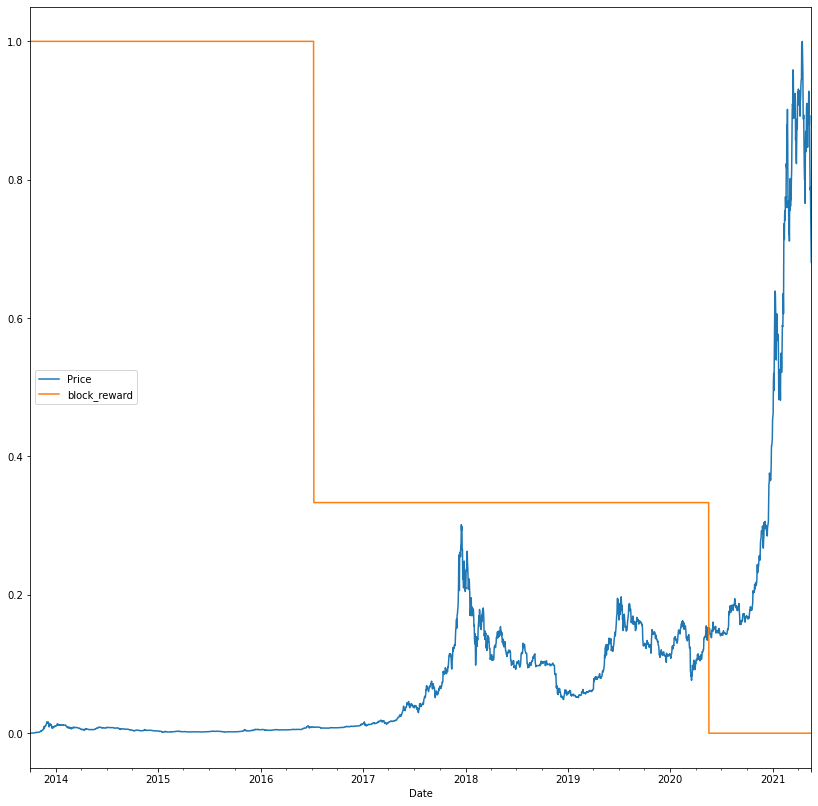

In [124]:
# Plot the block reward vs price overtime
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                                            columns=bitcoin_prices_block.columns,
                                                                                            index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(14,14));

In [125]:
## Making a windowed dataset with pandas

# Previously, we've turned our univariate time series into windowed dataset using the
# helper functions above. 

# However, since we've got multivariate data, these functions won't work. 

# Not to worry, we can use the pandas.DataFrame.shift() methot to window our multivariate data. 


In [126]:
# Setup dataset hyperparameters 

HORIZON = 1
WINDOW_SIZE = 7 

In [127]:
# Make a copy of the Bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

bitcoin_prices_windowed.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [128]:
# Add windowed columns

for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
    
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [129]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [130]:
# What we've done is created a way to window our dataset directly from a pandas dataframe.

# '''  
# [0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
# [1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
# [2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
# '''  



In [131]:
# Create X (windows) and y (horizons) features

X = bitcoin_prices_windowed.dropna().drop("Price",axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [132]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [133]:
# Make train and test sets using indexing

split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test   = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [134]:
tf.random.set_seed(42)

model_6 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON,activation="linear")
],name="model_6_dense_multivariate")
model_6.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["mae","mse"]
)

history_model_6 = model_6.fit(
    X_train,
    y_train,
    epochs = 100,
    batch_size = 128,
    verbose=1,
    validation_data=(X_test,y_test),
    callbacks = [create_model_checkpoint(model_6.name)] 

)

Epoch 1/100
15/18 [========================>.....] - ETA: 0s - loss: 1391.9371 - mae: 1391.9371 - mse: 6081305.0000 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 1234.6805 - mae: 1234.6805 - mse: 5282006.0000 - val_loss: 2061.9075 - val_mae: 2061.9075 - val_mse: 11377606.0000
Epoch 2/100
16/18 [=========================>....] - ETA: 0s - loss: 362.2567 - mae: 362.2567 - mse: 527639.9375INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 351.5054 - mae: 351.5054 - mse: 499358.0312 - val_loss: 1908.6731 - val_mae: 1908.6731 - val_mse: 8719442.0000
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 237.7690 - mae: 237.7690 - mse: 277717.9688INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 235.4153 - mae: 235.4153 - mse: 276006.8125 - val_loss: 1329.0583 - val_mae: 1329.0583 - val_mse: 4991872.5000
Epoch 4/100
17/18 [===========================>..] - ETA: 0s - loss: 210.6493 - mae: 210.6493 - mse: 223187.0938INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 208.6112 - mae: 208.6112 - mse: 219502.6875 - val_loss: 1102.1342 - val_mae: 1102.1342 - val_mse: 3934655.5000
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 196.5770 - mae: 196.5770 - mse: 204309.3594 - val_loss: 1107.8473 - val_mae: 1107.8473 - val_mse: 3822058.7500
Epoch 6/100
15/18 [========================>.....] - ETA: 0s - loss: 187.5235 - mae: 187.5235 - mse: 180408.8438INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 187.2244 - mae: 187.2244 - mse: 185754.2188 - val_loss: 1036.1720 - val_mae: 1036.1720 - val_mse: 3602706.0000
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 187.1519 - mae: 187.1519 - mse: 189044.4219INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 45ms/step - loss: 182.0246 - mae: 182.0246 - mse: 177482.7500 - val_loss: 1019.2927 - val_mae: 1019.2927 - val_mse: 3334209.0000
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 174.2125 - mae: 174.2125 - mse: 166109.2188INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 175.7059 - mae: 175.7059 - mse: 166085.1875 - val_loss: 977.8487 - val_mae: 977.8487 - val_mse: 3114359.2500
Epoch 9/100
16/18 [=========================>....] - ETA: 0s - loss: 173.7910 - mae: 173.7910 - mse: 165005.7500INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 170.1784 - mae: 170.1784 - mse: 157931.9531 - val_loss: 954.4036 - val_mae: 954.4036 - val_mse: 2930253.0000
Epoch 10/100
16/18 [=========================>....] - ETA: 0s - loss: 161.9759 - mae: 161.9759 - mse: 148105.2344INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 164.4430 - mae: 164.4430 - mse: 149624.9219 - val_loss: 913.5146 - val_mae: 913.5146 - val_mse: 2725003.0000
Epoch 11/100
15/18 [========================>.....] - ETA: 0s - loss: 159.6542 - mae: 159.6542 - mse: 140465.5625INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 158.6892 - mae: 158.6892 - mse: 137497.7188 - val_loss: 874.2505 - val_mae: 874.2505 - val_mse: 2503843.0000
Epoch 12/100
16/18 [=========================>....] - ETA: 0s - loss: 151.8416 - mae: 151.8416 - mse: 127497.5000INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 152.0732 - mae: 152.0732 - mse: 128314.7891 - val_loss: 861.0416 - val_mae: 861.0416 - val_mse: 2380360.7500
Epoch 13/100
18/18 [==============================] - 0s 6ms/step - loss: 151.1057 - mae: 151.1057 - mse: 126204.9062 - val_loss: 886.1204 - val_mae: 886.1204 - val_mse: 2378219.5000
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 144.8079 - mae: 144.8079 - mse: 113688.0781INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 147.5482 - mae: 147.5482 - mse: 118020.3516 - val_loss: 837.8613 - val_mae: 837.8613 - val_mse: 2199053.2500
Epoch 15/100
15/18 [========================>.....] - ETA: 0s - loss: 145.3921 - mae: 145.3921 - mse: 120479.7969INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 142.3497 - mae: 142.3497 - mse: 113288.9766 - val_loss: 794.4786 - val_mae: 794.4786 - val_mse: 2039430.0000
Epoch 16/100
13/18 [====================>.........] - ETA: 0s - loss: 140.2361 - mae: 140.2361 - mse: 104783.9609INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 137.5206 - mae: 137.5206 - mse: 106858.8828 - val_loss: 778.4050 - val_mae: 778.4050 - val_mse: 1954906.7500
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 132.5314 - mae: 132.5314 - mse: 98830.5078INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 135.8190 - mae: 135.8190 - mse: 104154.0078 - val_loss: 772.4529 - val_mae: 772.4529 - val_mse: 1901520.2500
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 140.1422 - mae: 140.1422 - mse: 108664.9453INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 134.8562 - mae: 134.8562 - mse: 102955.3828 - val_loss: 747.4801 - val_mae: 747.4801 - val_mse: 1804913.1250
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 130.3347 - mae: 130.3347 - mse: 96741.8438 - val_loss: 761.0552 - val_mae: 761.0552 - val_mse: 1809536.5000
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 128.0154 - mae: 128.0154 - mse: 92614.7422 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 84ms/step - loss: 128.6775 - mae: 128.6775 - mse: 93855.6953 - val_loss: 701.8977 - val_mae: 701.8977 - val_mse: 1664375.2500
Epoch 21/100
15/18 [========================>.....] - ETA: 0s - loss: 128.8097 - mae: 128.8097 - mse: 91347.3359 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 129.5576 - mae: 129.5576 - mse: 95792.0938 - val_loss: 691.0127 - val_mae: 691.0127 - val_mse: 1604252.8750
Epoch 22/100
14/18 [======================>.......] - ETA: 0s - loss: 131.2601 - mae: 131.2601 - mse: 101738.2578INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 125.8060 - mae: 125.8060 - mse: 90966.0703 - val_loss: 684.4120 - val_mae: 684.4120 - val_mse: 1561598.8750
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 125.5263 - mae: 125.5263 - mse: 90267.1328 - val_loss: 692.1295 - val_mae: 692.1295 - val_mse: 1560175.7500
Epoch 24/100
16/18 [=========================>....] - ETA: 0s - loss: 123.2349 - mae: 123.2349 - mse: 88224.6406INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 122.4765 - mae: 122.4765 - mse: 86726.7812 - val_loss: 674.2214 - val_mae: 674.2214 - val_mse: 1504522.0000
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 124.4100 - mae: 124.4100 - mse: 87115.0469INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 121.1171 - mae: 121.1171 - mse: 84265.1797 - val_loss: 669.6443 - val_mae: 669.6443 - val_mse: 1546641.3750
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 127.2623 - mae: 127.2623 - mse: 87325.4219 - val_loss: 690.0407 - val_mae: 690.0407 - val_mse: 1606596.7500
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 124.2509 - mae: 124.2509 - mse: 85340.0156 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 124.6204 - mae: 124.6204 - mse: 87496.1562 - val_loss: 643.9725 - val_mae: 643.9725 - val_mse: 1437326.3750
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 118.2544 - mae: 118.2544 - mse: 81311.5938 - val_loss: 656.2766 - val_mae: 656.2766 - val_mse: 1431099.3750
Epoch 29/100
15/18 [========================>.....] - ETA: 0s - loss: 120.7275 - mae: 120.7275 - mse: 83534.5859INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 39ms/step - loss: 119.6374 - mae: 119.6374 - mse: 82266.8672 - val_loss: 633.4545 - val_mae: 633.4545 - val_mse: 1375091.6250
Epoch 30/100
15/18 [========================>.....] - ETA: 0s - loss: 120.3370 - mae: 120.3370 - mse: 82155.6016INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 49ms/step - loss: 119.5001 - mae: 119.5001 - mse: 81478.4141 - val_loss: 625.3953 - val_mae: 625.3953 - val_mse: 1360550.3750
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5633 - mae: 114.5633 - mse: 78351.5078 - val_loss: 668.5062 - val_mae: 668.5062 - val_mse: 1448342.5000
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 117.7110 - mae: 117.7110 - mse: 80543.2500INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 116.9750 - mae: 116.9750 - mse: 80914.8672 - val_loss: 617.1060 - val_mae: 617.1060 - val_mse: 1328562.0000
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2439 - mae: 115.2439 - mse: 78368.8125 - val_loss: 649.0987 - val_mae: 649.0987 - val_mse: 1390663.1250
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 114.5187 - mae: 114.5187 - mse: 78831.3438 - val_loss: 632.1377 - val_mae: 632.1377 - val_mse: 1383321.5000
Epoch 35/100
16/18 [=========================>....] - ETA: 0s - loss: 113.8353 - mae: 113.8353 - mse: 78506.5234INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 113.6357 - mae: 113.6357 - mse: 76610.7734 - val_loss: 607.4173 - val_mae: 607.4173 - val_mse: 1299839.2500
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2605 - mae: 115.2605 - mse: 77254.8203 - val_loss: 626.4316 - val_mae: 626.4316 - val_mse: 1328737.2500
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 113.6959 - mae: 113.6959 - mse: 75871.9141 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 113.7021 - mae: 113.7021 - mse: 76909.3203 - val_loss: 606.2318 - val_mae: 606.2318 - val_mse: 1299941.6250
Epoch 38/100
14/18 [======================>.......] - ETA: 0s - loss: 114.6104 - mae: 114.6104 - mse: 79649.4766INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 111.4061 - mae: 111.4061 - mse: 75382.8672 - val_loss: 603.2921 - val_mae: 603.2921 - val_mse: 1290359.3750
Epoch 39/100
16/18 [=========================>....] - ETA: 0s - loss: 114.5763 - mae: 114.5763 - mse: 77977.8750 INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 35ms/step - loss: 112.7722 - mae: 112.7722 - mse: 75144.9453 - val_loss: 596.0060 - val_mae: 596.0060 - val_mse: 1267989.1250
Epoch 40/100
15/18 [========================>.....] - ETA: 0s - loss: 111.1719 - mae: 111.1719 - mse: 76700.3359INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 110.5418 - mae: 110.5418 - mse: 73266.8984 - val_loss: 593.2171 - val_mae: 593.2171 - val_mse: 1259326.1250
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8671 - mae: 110.8671 - mse: 73493.2422 - val_loss: 609.1066 - val_mae: 609.1066 - val_mse: 1298277.5000
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 115.7249 - mae: 115.7249 - mse: 78316.4531 - val_loss: 607.4874 - val_mae: 607.4874 - val_mse: 1271582.3750
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 111.3313 - mae: 111.3313 - mse: 72553.7656 - val_loss: 606.2032 - val_mae: 606.2032 - val_mse: 1287465.7500
Epoch 44/100
15/18 [========================>.....] - ETA: 0s - loss: 108.7434 - mae: 108.7434 - mse: 71892.2656INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 109.7027 - mae: 109.7027 - mse: 72483.3594 - val_loss: 586.1216 - val_mae: 586.1216 - val_mse: 1236946.6250
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8748 - mae: 107.8748 - mse: 72189.5078 - val_loss: 593.8448 - val_mae: 593.8448 - val_mse: 1256012.3750
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8641 - mae: 109.8641 - mse: 72053.3203 - val_loss: 586.4579 - val_mae: 586.4579 - val_mse: 1224364.1250
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3586 - mae: 112.3586 - mse: 74881.6562 - val_loss: 655.4484 - val_mae: 655.4484 - val_mse: 1368205.3750
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 109.1614 - mae: 109.1614 - mse: 72981.2344 - val_loss: 598.7231 - val_mae: 598.7231 - val_mse: 1244141.1250
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 109.3029 - mae: 109.3029 - m

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 41ms/step - loss: 110.4068 - mae: 110.4068 - mse: 73627.0078 - val_loss: 575.7750 - val_mae: 575.7750 - val_mse: 1197730.6250
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 108.6609 - mae: 108.6609 - mse: 71261.1328 - val_loss: 785.9762 - val_mae: 785.9762 - val_mse: 1798982.0000
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 124.9823 - mae: 124.9823 - mse: 82843.3594 - val_loss: 670.3788 - val_mae: 670.3788 - val_mse: 1435155.1250
Epoch 58/100
18/18 [==============================] - 0s 6ms/step - loss: 112.8591 - mae: 112.8591 - mse: 71915.3984 - val_loss: 580.2877 - val_mae: 580.2877 - val_mse: 1201587.6250
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 107.2513 - mae: 107.2513 - mse: 70587.5078 - val_loss: 597.5089 - val_mae: 597.5089 - val_mse: 1251076.7500
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 109.2322 - mae: 109.2322 - m

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 36ms/step - loss: 112.0475 - mae: 112.0475 - mse: 73420.1797 - val_loss: 575.5544 - val_mae: 575.5544 - val_mse: 1191944.1250
Epoch 66/100
18/18 [==============================] - 0s 6ms/step - loss: 111.2831 - mae: 111.2831 - mse: 71301.0312 - val_loss: 590.7808 - val_mae: 590.7808 - val_mse: 1225398.0000
Epoch 67/100
18/18 [==============================] - 0s 6ms/step - loss: 106.7917 - mae: 106.7917 - mse: 69382.4609 - val_loss: 586.8846 - val_mae: 586.8846 - val_mse: 1218029.0000
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2987 - mae: 112.2987 - mse: 70631.5859 - val_loss: 696.5298 - val_mae: 696.5298 - val_mse: 1492199.0000
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 124.7808 - mae: 124.7808 - mse: 81109.6094 - val_loss: 698.5273 - val_mae: 698.5273 - val_mse: 1498615.2500
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 119.3443 - mae: 119.3443 - m

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 37ms/step - loss: 106.7710 - mae: 106.7710 - mse: 70055.2656 - val_loss: 573.6143 - val_mae: 573.6143 - val_mse: 1185168.8750
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 110.2485 - mae: 110.2485 - mse: 71589.1562 - val_loss: 618.8953 - val_mae: 618.8953 - val_mse: 1289602.7500
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 105.5330 - mae: 105.5330 - mse: 69883.3125 - val_loss: 574.9454 - val_mae: 574.9454 - val_mse: 1189283.2500
Epoch 75/100
18/18 [==============================] - 0s 6ms/step - loss: 107.3177 - mae: 107.3177 - mse: 69894.7422 - val_loss: 606.1971 - val_mae: 606.1971 - val_mse: 1240846.5000
Epoch 76/100
18/18 [==============================] - 0s 6ms/step - loss: 107.8084 - mae: 107.8084 - mse: 70983.0859 - val_loss: 582.2407 - val_mae: 582.2407 - val_mse: 1206272.7500
Epoch 77/100
16/18 [=========================>....] - ETA: 0s - loss: 109.1200 - mae: 109.1200 - mse: 

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 46ms/step - loss: 107.2528 - mae: 107.2528 - mse: 69628.3516 - val_loss: 571.8566 - val_mae: 571.8566 - val_mse: 1180512.7500
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 106.2309 - mae: 106.2309 - mse: 69009.0156 - val_loss: 572.2828 - val_mae: 572.2828 - val_mse: 1174658.7500
Epoch 79/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8568 - mae: 105.8568 - mse: 70072.8359 - val_loss: 596.5466 - val_mae: 596.5466 - val_mse: 1236697.0000
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 107.8419 - mae: 107.8419 - mse: 70822.3047 - val_loss: 577.2399 - val_mae: 577.2399 - val_mse: 1181263.1250
Epoch 81/100
17/18 [===========================>..] - ETA: 0s - loss: 104.7596 - mae: 104.7596 - mse: 68632.0078INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 44ms/step - loss: 105.1100 - mae: 105.1100 - mse: 68809.2344 - val_loss: 568.4897 - val_mae: 568.4897 - val_mse: 1169003.7500
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1867 - mae: 114.1867 - mse: 75576.8359 - val_loss: 592.5615 - val_mae: 592.5615 - val_mse: 1228616.0000
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9631 - mae: 107.9631 - mse: 70494.3125 - val_loss: 651.6219 - val_mae: 651.6219 - val_mse: 1362900.2500
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 109.6690 - mae: 109.6690 - mse: 71213.1719 - val_loss: 568.9340 - val_mae: 568.9340 - val_mse: 1170230.8750
Epoch 85/100
18/18 [==============================] - 0s 6ms/step - loss: 105.8219 - mae: 105.8219 - mse: 69465.5938 - val_loss: 571.5331 - val_mae: 571.5331 - val_mse: 1169861.6250
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 104.8628 - mae: 104.8628 - m

INFO:tensorflow:Assets written to: model_experiments\model_6_dense_multivariate\assets


18/18 [==============================] - 1s 39ms/step - loss: 106.1837 - mae: 106.1837 - mse: 69945.1250 - val_loss: 568.0361 - val_mae: 568.0361 - val_mse: 1166216.0000
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 115.8590 - mae: 115.8590 - mse: 71867.6016 - val_loss: 639.6246 - val_mae: 639.6246 - val_mse: 1311233.2500


In [135]:
# Evaluate multivariate model

model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 639.6246 - mae: 639.6246 - mse: 1311233.3750


[639.6245727539062, 639.6245727539062, 1311233.375]

In [136]:
# Load in and evaluate best performing model

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 568.0361 - mae: 568.0361 - mse: 1166216.0000


[568.0360717773438, 568.0360717773438, 1166216.0]

In [137]:
# Make predictions with multivariate model

model_6_preds =tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 1ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8849.693 , 8777.459 , 9053.712 , 8753.832 , 8731.5205, 8777.638 ,
       8673.611 , 8509.444 , 8475.512 , 8533.936 ], dtype=float32)>

In [138]:
# Evaluate predictions to get eval metrics

model_6_results = evaluate_preds(y_true=y_test,y_pred=model_6_preds)
model_6_results

{'mae': 568.036,
 'mse': 1166216.0,
 'rmse': 1079.9148,
 'mape': 2.546599,
 'mase': 0.99788195}

In [139]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [140]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [141]:
## Model 7: N-BEATS algorithm

# Let's now try build the biggest baddest (though maybe not the baddest, as in, it might perform really well...) time series forecasting model we've built so far. 


# More specifically, we're going to be replicating the algorithm in Figure 1 from the following
# paper: https://arxiv.org/pdf/1905.10437.pdf 

# Why?

# * This will allow us to practice replicating a paper with TensorFlow code
# * We will see how to use TensorFlow layer subclassing (to make our own custom layers)
# * Get experience using the Functional API to create a custom architecture.
# * Potentially get state of the art results on our problem 


In [142]:
### Building and testing the N-BEATS block layer

# Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.
# To create custom layers and models in TensorFlow we can use subclassing:
# https://www.tensorflow.org/guide/keras/custom_layers_and_models




In [224]:
# Create NBeatBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):

    def __init__(self,
                input_size:int,
                theta_size:int,
                horizon: int,
                n_neurons:int,
                n_layers:int,
                **kwargs):    # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, name, ...)

        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon    = horizon
        self.n_neurons  = n_neurons 
        self.n_layers   = n_layers         
        
        # Block contains stack of 4 (n_layers = 4) fully connected layers each has ReLU activation

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

        # Output of block is a theta layer with linear activation

        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear",name="Theta")

    def call(self, inputs):

        x = inputs 

        for layer in self.hidden:

            x = layer(x)
        
        theta = self.theta_layer(x)

        # Output the backcast and the forecast from theta

        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]

        return backcast, forecast

In [225]:
# Let's test our NBeatsBlock class

# To do we'll make some dummy inputs and outputs

In [226]:
WINDOW_SIZE = 7
HORIZON = 1

In [227]:
# Set up dummpy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                      theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                      horizon=HORIZON,
                                      n_neurons=128,
                                      n_layers=4)

In [228]:
# Create dummy inputs (have to be same size as input_size)

dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # Input shape to the model has to reflect dense layer input requirements ndim
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>

In [229]:
# Pass dummy inputs to dummy NBeatsBlock layer

backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no trainig of the model)

print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [-1.2772614   0.40849113  2.9308908  -9.438014   -3.28594    -2.0860548
 -5.825688  ]
Forecast: 3.5376338958740234


In [149]:
## Preparing data for the N-BEATS algorithm using 'tf.data'  

# To make our input data load as fast as possible we're going to be adhering to the 
# performant data pipeline steps in the tf.data guide. 


In [230]:
HORIZON = 1
WINDOW_SIZE = 7

In [231]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [232]:
# Add windowed columns


bitcoin_prices_n_beats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):

    bitcoin_prices_n_beats[f"Price+{i+1}"] = bitcoin_prices_n_beats["Price"].shift(periods=i+1)

bitcoin_prices_n_beats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [233]:
# Make features and labels 

X = bitcoin_prices_n_beats.dropna().drop("Price",axis=1)
y = bitcoin_prices_n_beats.dropna()["Price"]

# Make train and test sets

split_size = int(len(X) * 0.8)

X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test   = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [234]:
# Time to make our dataset performant using tf.data API

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset   = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset  = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset    = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features,labels)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset  = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset  = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [155]:
### Setting up hyperparameters for N-BEATS algorithm

# The N-BEATS algorithm has a fair few number of parameters, many of them can be found
# in Table 18: https://arxiv.org/pdf/1905.10437.pdf 

In [235]:
# Values from N-BEATS paper

N_EPOCHS  = 5000
N_NEURONS = 512
N_LAYERS  = 4
N_STACKS  = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON


INPUT_SIZE, THETA_SIZE

(7, 8)

In [157]:
## Getting ready for residual connections

# Before we can craft our N-BEATS model, we need two layers for the residual connections 
# (substract and add). 

# The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper). 

# For more on residual connections see: https://en.wikipedia.org/wiki/Residual_neural_network 

# And here: https://paperswithcode.com/method/resnet 


In [236]:
# Make tensors 

tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Substract

substracted = tf.keras.layers.subtract([tensor_1, tensor_2])

# Add

added = tf.keras.layers.add([tensor_1, tensor_2])

# Get outputs

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Substracted: {substracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Substracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [237]:
tensor_1, tensor_2

(<tf.Tensor: shape=(10,), dtype=int32, numpy=array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])>,
 <tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])>)

In [160]:
### Building, compiling and fitting the N-BEATS algorithm

# 1. Setup an instance of the N-BEATS block layer using 'NBeatsBlock' (this'll be the initial
# block used for the network, the rest will be created as part of stacks)
# 2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
# 3. Make the initial backcast and forecasts for the model with the layer created in (1)
# 4. Use for loop to create stacks of block layers
# 5. Use the 'NBeatsBlock' class within the for loop in (4) to create blocks which return
# backcasts and block-level forecasts 
# 6. Create the double residual stacking using subtract and add layers
# 7. Put the model inputs and outputs together using 'tf.keras.Model()'  
# 8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to
# keep it inline with our other models) and Adam optimizer with default setting as per
# selection 5.2 of N-BEAST paper 
# 9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, 
# we'll use a couple of callbacks: 
# * Early Stopping - because the model will be training for so long, we'll stop it early
# if it stops improving
# * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce
# the amount it updated its weights each time (take smaller steps towards best performance)



In [238]:
%time 

tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock

nbeats_block_layer = NBeatsBlock(
                    input_size=INPUT_SIZE,
                    theta_size=THETA_SIZE,
                    horizon=HORIZON,
                    n_neurons=N_NEURONS,
                    n_layers=N_LAYERS,
                    name="InitialBlock")


# 2. Create input to stack

stack_input = tf.keras.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input(backwards prediction + horizon prediction)

residuals, forecast = nbeats_block_layer(stack_input)

# 4. Create stacks of block layers

for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

    # 5. Use the NBeatsBlock to calculate the backcast as well as the forecast

    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"NBeatsBlock_{i}"
    )(residuals) # pass in the residuals

    # 6. Create the double residual stacking

    residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
    forecast  = tf.keras.layers.add([forecast, block_forecast],name=f"add_{i}")


# 7. Put the stack model together

model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile model with MAE loss
model_7.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
)

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks

history_model_7 = model_7.fit(
                        train_dataset,
                        epochs=N_EPOCHS,
                        validation_data=test_dataset,
                        verbose=0,
                        callbacks=[tf.keras.callbacks.EarlyStopping(
                            monitor="val_loss",
                            patience=200,
                            restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(
                            monitor="val_loss",
                            patience=100,
                            verbose=1)])

CPU times: total: 0 ns
Wall time: 997 µs

Epoch 958: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1746: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1846: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.


In [239]:
# Evaluate N-BEATS model on the test dataset

model_7.evaluate(test_dataset)


1/1 [==============================] - 0s 135ms/step - loss: 890.8889


890.8888549804688

In [163]:
# Make predictions with N-BEATS model

model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]


1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.141, 8772.026, 9013.416, 8766.086, 8744.043, 8735.573,
       8663.993, 8497.035, 8471.233, 8507.253], dtype=float32)>

In [164]:
model_7_results = evaluate_preds(y_true=y_test,y_pred=model_7_preds)
model_7_results

{'mae': 576.4447,
 'mse': 1179527.2,
 'rmse': 1086.0604,
 'mape': 2.6427298,
 'mase': 1.0126537}

In [165]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [166]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [167]:
# Woah.. even with all of those special layers and hand-crafted network, it looks like the
# N-BEATS model doesn't perform as wel as model_1 or the original naive forecast. 

# This goes to show the power of smaller networks as well as the fact not all larger models
# are better suited for a certain type of data. 



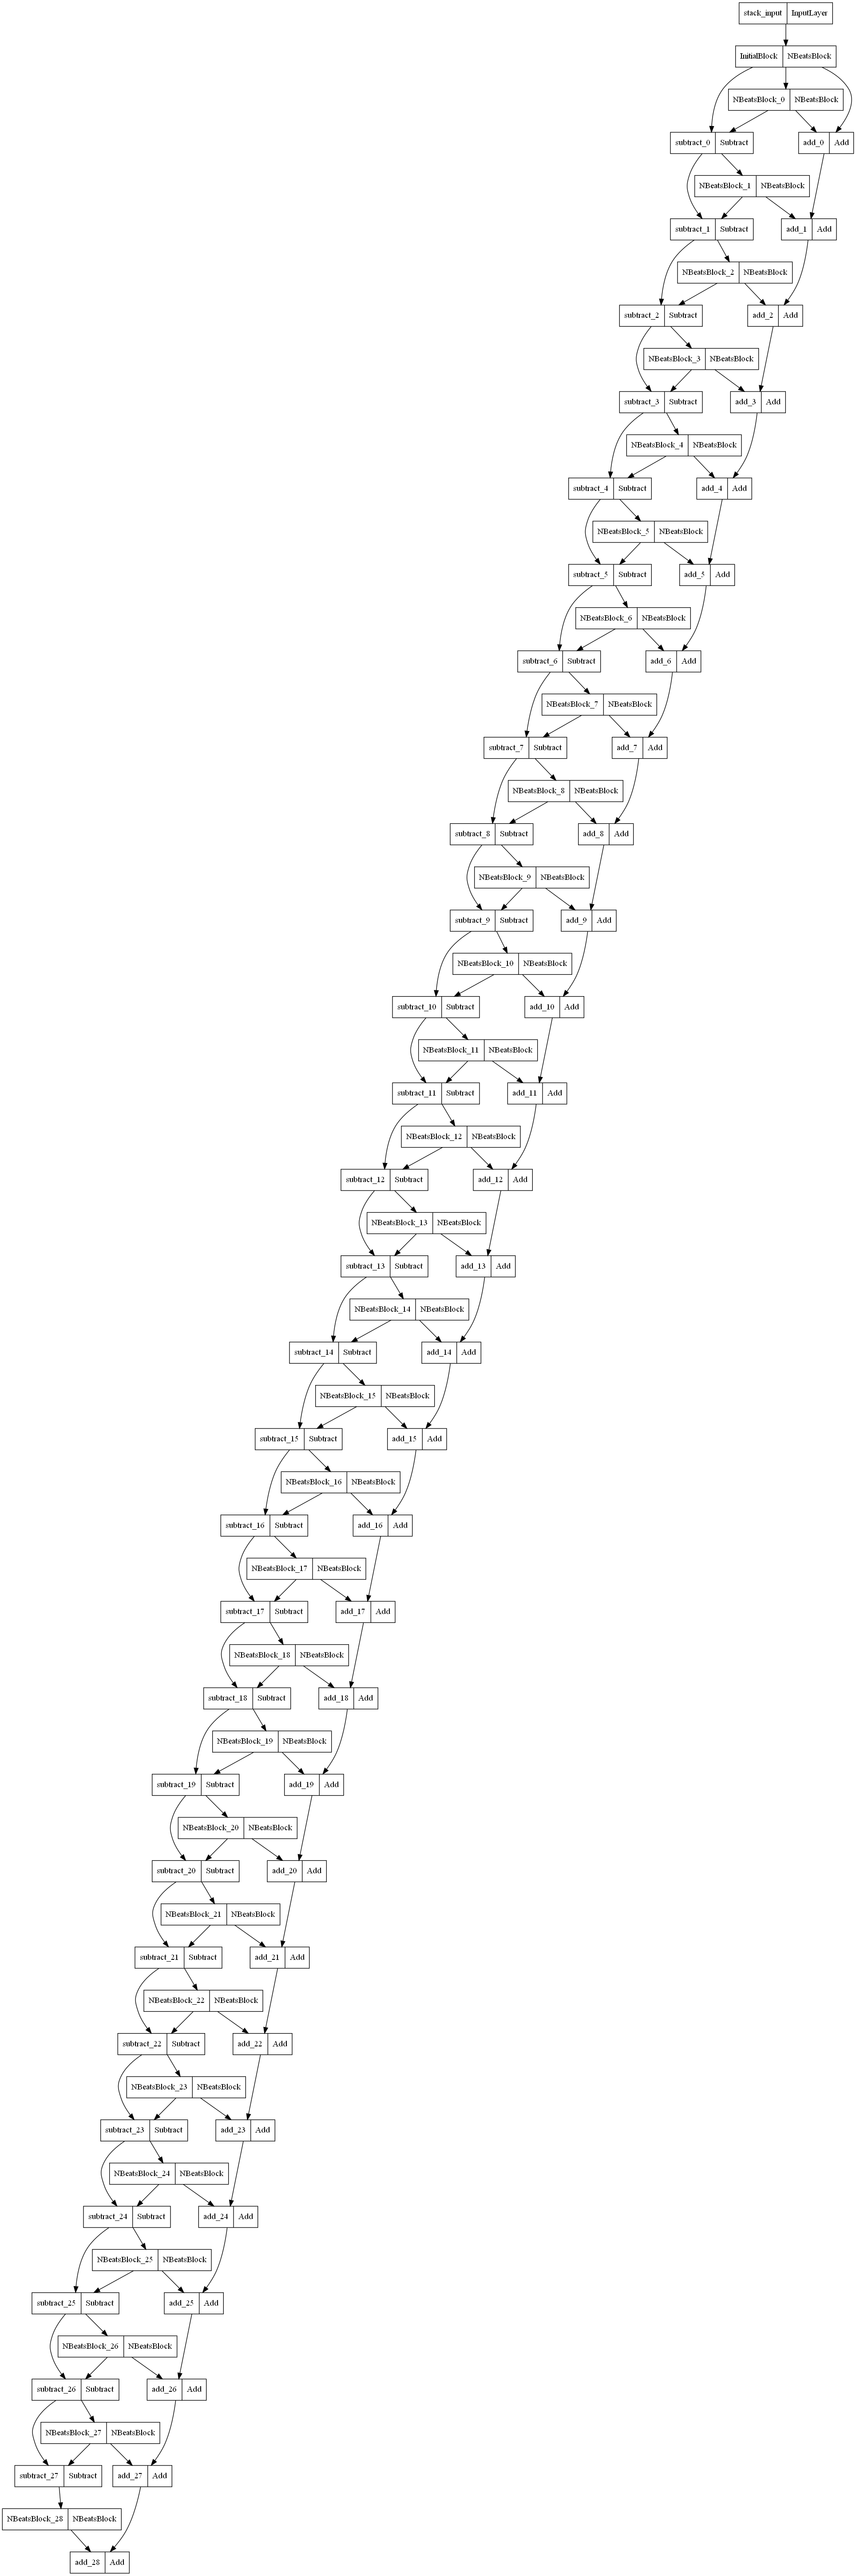

In [168]:
### Plotting the N-BEATS architecture we've created

# Plot the N-BEATS model and inspect the architecture

from tensorflow.keras.utils import plot_model

plot_model(model_7)

In [169]:
### Model 8: Creating an ensemble (stacking different models together)

# An ensemble leverages the wisdom of the crowd effect.
# It combines many **different** models to dredict a common goal. 


In [170]:
HORIZON, WINDOW_SIZE

(1, 7)

In [171]:
# Constructing and fitting and ensemble of models (using different loss functions)

In [172]:
def get_ensemble_models(
    horizon=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    num_iter=10,
    num_epochs=1000,
    loss_fns=["mae","mse","mape"]):

    """  
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

    For example, if num_iter=10, a list of 30 trained models will be returned:
    10 * len(["mae","mse","mape"]). 
    """

    # Make empty list for trained ensemble models

    ensemble_models = []

    # Create num_iter number of models per loss function

    for i in range(num_iter):
        
        # Build and fit a new model with a different loss function

        for loss_function in loss_fns:

            print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

            # Construct a simple model (similar to model_1)

            model = tf.keras.Sequential([ 
                # Initialize dense layers with normal distribution for estimating prediction intervals later on
                tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
                tf.keras.layers.Dense(128,kernel_initializer="he_normal",activation="relu"),
                tf.keras.layers.Dense(HORIZON)
            ])

            # Compile simple model with current loss function

            model.compile(
                loss=loss_function,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

            # Fit the current model

            model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=200,
                    restore_best_weights=True),
                          tf.keras.callbacks.ReduceLROnPlateau(
                            monitor="val_loss",
                            patience=100,
                            verbose=1
                        
                          )]
            )

            # Append fitted model to list of ensemble models

            ensemble_models.append(model)

    return ensemble_models



In [173]:
%time 

# Get list of trained ensemble models 

ensemble_models = get_ensemble_models(num_iter=5,
                                        num_epochs=1000)

CPU times: total: 0 ns
Wall time: 996 µs
Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 860: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 572: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 687: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 787: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 422: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 522: ReduceLROnPlateau reducing learning rate to 1.00000

In [174]:
len(ensemble_models)

15

In [175]:
ensemble_models

In [176]:
## Make predictions with our ensemble model

# Create a function which uses a list of trained models to make and return a list of predictions

def make_ensemble_preds(ensemble_models, data):

    ensemble_preds = []

    for model in ensemble_models:

        preds = model.predict(data)
        ensemble_preds.append(preds)

    return tf.constant(tf.squeeze(ensemble_preds))

In [177]:
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models, data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8803.441,  8778.764,  9031.256, ..., 50170.36 , 49194.402,
        46597.53 ],
       [ 8760.974,  8736.698,  9048.665, ..., 49289.57 , 48533.777,
        45318.77 ],
       [ 8745.424,  8733.031,  9101.386, ..., 49267.17 , 47660.434,
        45370.047],
       ...,
       [ 8900.6  ,  8755.887,  9034.464, ..., 49359.344, 49356.594,
        46365.016],
       [ 8730.555,  8805.965,  9105.109, ..., 49607.277, 48548.082,
        45052.77 ],
       [ 8822.861,  8768.188,  9048.345, ..., 49775.97 , 48100.133,
        45893.246]], dtype=float32)>

In [178]:
ensemble_preds_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_preds_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8785.531, 8772.302, 9062.639, 8730.988, 8741.901, 8709.6  ,
       8665.59 , 8477.311, 8452.743, 8526.501], dtype=float32)>

In [179]:
ensemble_preds_median = np.median(ensemble_preds, axis=0)
ensemble_preds_median[:10]

array([8778.977, 8775.757, 9053.888, 8719.503, 8738.087, 8712.957,
       8664.861, 8478.888, 8450.964, 8529.686], dtype=float32)

In [180]:
# Evaluate ensemble model predictions

ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds_mean)
ensemble_results

{'mae': 566.8895,
 'mse': 1145000.9,
 'rmse': 1070.0471,
 'mape': 2.5793295,
 'mase': 0.9958679}

In [181]:
# Evaluate ensemble model predictions

ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds_median)
ensemble_results 

{'mae': 567.206,
 'mse': 1146888.5,
 'rmse': 1070.9288,
 'mape': 2.5773952,
 'mase': 0.99642384}

In [182]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

In [183]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [184]:
### Plotting the prediction intervals (uncertainty estimates) of our ensemble

# So far we've been making point predictions with our models. 

# E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be 50,000 USD

# Wouldn't it be helpful if we knew a range of where that prediction came from? 


# Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

# One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:

# 1. Take the predictions from a number of randomly initialized models (we've got this thanks to
# our ensemble models)
# 2. Measure the standard deviation of the predictions.
# 3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of 
# observations fall within 1.96 standard deviations of the mean)
# 4. To the get the prediction interval upper and lower bounds, add and subtract the value obtained
# in (3) to the mean/median of the predictions made in (1) 

In [185]:
# Find upper and lower bounds of ensemble predictions

def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

    # 2. Measure the standard deviation of the predictions

    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96

    interval = 1.96 * std 

    # 4. Get the prediction interval upper and lower bounds

    preds_mean = tf.reduce_mean(preds, axis=0)
    lower, upper = preds_mean - interval, preds_mean + interval

    return lower, upper 

In [186]:
# Get the upper and lower bounds of the 95% prediction interval

lower, upper = get_upper_lower(preds=ensemble_preds)


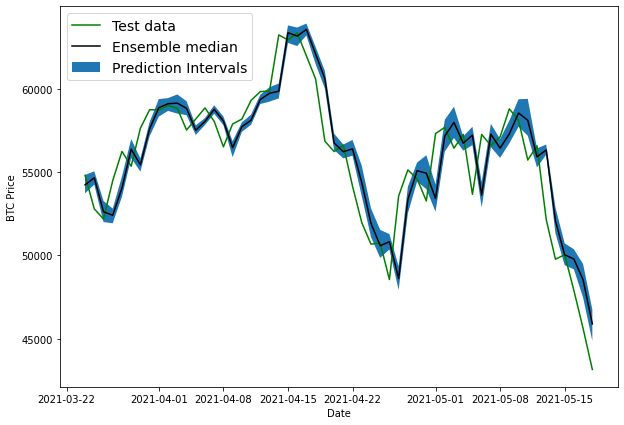

In [187]:
# Get the median/mean values of our ensemble preds

ensemble_preds_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)

offset = 500

plt.figure(figsize=(10,7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_preds_median[offset:],"k-",label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot upper and lower bounds, let's use fill_between

plt.fill_between(
    X_test.index[offset:],
    (lower)[offset:],
    (upper)[offset:],
    label="Prediction Intervals"
)
plt.legend(loc="upper left",fontsize=14);


In [188]:
# So far all of our models predictions have been lagging behind the test data... 

# As is they're replicating what the naive model does and just predict previous timestep as the next timestep. 


# Note These prediction intervals are estimates themselves. Ande they have been created with the
# assumption that our model's data is from a normal distribution. 



In [189]:
### Aside: two types of uncertainty (coconut and subway)

# Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:

# 1. What can my model know? (with perfect data, what's possible for a model to learn?)
# 2. What doesn't my model know? (what can a model never predict? Or would it helpful if a 
# model could tell you that when it's making a prediction, it doesn't actually know if it's right
# or not?)


# There are two major types of uncertainty in machine learning you should know about:

# * Aleatoric uncertainty - this type of uncertainty cannot be reduced and it is often referred as
# data uncertainty or subway uncertainty
# * Epistemic uncertainty - this type of uncertainty can be reduced, it also referred to as 
# "model" or "coconut" uncertainty

In [190]:
### Model 9: Train a model on the fulk historical data to make predictions into the future

# So far all of our models have predicted on the test dataset, this is only a pseudofuture. 
# Let's build a model which is capable of predicting into the future! 



In [191]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [192]:
HORIZON, WINDOW_SIZE

(1, 7)

In [193]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [194]:
# Train model on entire data to make predictions for the next day

X_all = bitcoin_prices_windowed.dropna().drop(["Price","block_reward"],axis=1).to_numpy()

y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [195]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all   = tf.data.Dataset.from_tensor_slices(y_all)

train_dataset = tf.data.Dataset.zip((features_dataset_all,labels_dataset_all))

BATCH_SIZE = 1024
dataset_all = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [196]:
tf.random.set_seed(42)

model_9 = tf.keras.Sequential([ 
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dense(HORIZON)
],name="model_9_future_model")

model_9.compile( 
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam()
    
)

model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [197]:
### Make predictions into future

# How many timesteps to predict into the future?

INTO_FUTURE = 14

In [198]:
# To make predictions into the future we want a function which:

# 1. Takes an input:

# * a list of values (Bitcoin historical data)
# * a trained model (such as model_9)
# * a window into the future to predict (our INTO_FUTURE variable)
# * the window size a model was trained on ('WINDOW_SIZE') - the model can only predict on the same
# kind of data it was trainde on 

# 2. Creates an empty list for future forecasts (this will be returned at the end of the end,
# when it's full of predictions) and extracts the last 'WINDOW_SIZE' values from the input values

# 3. Loop 'INTO_FUTURE' times making a prediction on 'WINDOW_SIZE' sequences which update to
# remove the first value and append the latest prediction


In [199]:
# 1. Create function to make predictions into the future

def make_future_forecasts(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """  
    Make future forecasts into_future steps after values ends.

    Returns future forecasts as a list of floats.
    """

    # 2. Create an empty list for future forecasts/prepare data to forecast on 

    future_forecast = []
    last_window = values[-WINDOW_SIZE:]

    # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each

    for _ in range(INTO_FUTURE):

        # Predict on the last window then append it again, again, again (our model will eventually start to make forecasts on its own forecast)
        future_pred = model.predict(tf.expand_dims(last_window,axis=0))
        print(f"Predicting on:n\ {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")

        # Append predictions to future_forecast

        future_forecast.append(tf.squeeze(future_pred).numpy())
        
        # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)

        last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
        
    return future_forecast

In [200]:
# Make forecasts into the future

future_forecast = make_future_forecasts(
    values=y_all,
    model=model_9,
    into_future=INTO_FUTURE,
    window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 62ms/step
Predicting on:n\ [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.46484375

1/1 [==============================] - 0s 22ms/step
Predicting on:n\ [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.46484375] -> Prediction: 50985.9453125

1/1 [==============================] - 0s 21ms/step
Predicting on:n\ [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.46484375 50985.9453125 ] -> Prediction: 48522.96875

1/1 [==============================] - 0s 23ms/step
Predicting on:n\ [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.46484375 50985.9453125  48522.96875   ] -> Prediction: 48137.203125

1/1 [==============================] - 0s 23ms/step
Predicting on:n\ [47885.62525472 45604.61575361 43144.47129086 55764.46484375
 50985.9453125  48522.96875    48137.203125 

In [201]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2021-05-14,49764.132082,6.25,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672,56583.849879
2021-05-15,50032.693137,6.25,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679,57107.120672
2021-05-16,47885.625255,6.25,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426,58788.209679
2021-05-17,45604.615754,6.25,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651,58102.191426
2021-05-18,43144.471291,6.25,45604.615754,47885.625255,50032.693137,49764.132082,52147.821187,56573.555472,55715.546651


In [202]:
# Plot future forecasts

def get_future_dates(start_date, into_future, offset=1):

    """  
    Returns array of datatime values ranging from start_data to start_date+into future

    """

    start_date = start_date + np.timedelta64(offset, "D")  # specify start date, "D" stands for day
    end_date   = start_date + np.timedelta64(into_future, "D") # specify end date

    return np.arange(start_date, end_date, dtype="datetime64[D]") 
    

In [203]:
# Last timestep of timesteps (currently np.datetime64 format)

last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [204]:
type(last_timestep)

pandas._libs.tslibs.timestamps.Timestamp

In [205]:
# Get next two week of timesteps

next_time_steps = get_future_dates(
    start_date=last_timestep,
    into_future=INTO_FUTURE)

next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

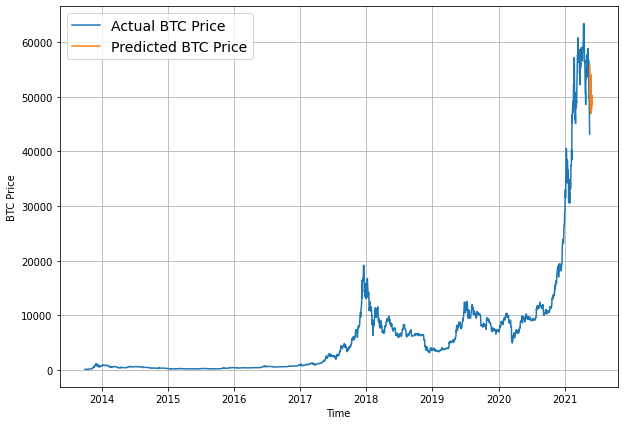

In [206]:
# Plot future prices predictions of Bitcoin 

plt.figure(figsize=(10,7))
plot_time_series(bitcoin_prices.index,bitcoin_prices, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-",label="Predicted BTC Price")

In [207]:
## Model 10: Why forecasting is BS (the turkey problem)

# Let's introduce the turkey problem to our BTC data (price of BTC falls 100x in one day)

btc_price_turkey = bitcoin_prices.copy()



In [208]:
btc_price_turkey = btc_price_turkey.reset_index().drop("Date",axis=1).squeeze(axis=1)

In [209]:
len(btc_price_turkey)

2787

In [210]:
btc_price_turkey = btc_price_turkey.to_numpy()

In [211]:
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [212]:
btc_price_turkey

array([  123.65499   ,   125.455     ,   108.58483   , ...,
       47885.62525472, 45604.61575361,   431.44471291])

In [213]:
# Get the timesteps for the turkey problem

btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

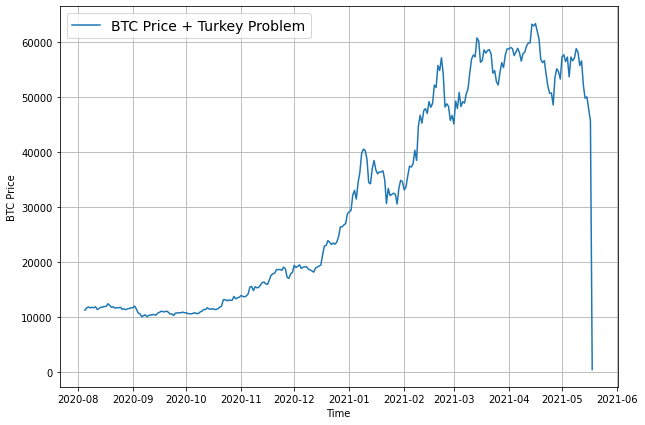

In [214]:



plt.figure(figsize=(10,7))
plot_time_series(
    timesteps=btc_timesteps_turkey,
    values=btc_price_turkey,
    format="-",
    label="BTC Price + Turkey Problem",
    start = 2500
    )

In [215]:
# Create train and test sets for turkey problem

full_windows, full_labels = make_windows(btc_price_turkey, window_size=7, horizon=1)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels, test_split=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [216]:
## Build a turkey model (model to predict on turkey data)

# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data

turkey_model = tf.keras.models.clone_model(model_1)

turkey_model._name = "model_10_turkey_model"

turkey_model.compile(
    loss = "mae",
    optimizer = tf.keras.optimizers.Adam(),

)

turkey_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_test,y_test),
    callbacks=[create_model_checkpoint(turkey_model.name)])

INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


INFO:tensorflow:Assets written to: model_experiments\model_10_turkey_model\assets


In [217]:
# Evaluate model on test data

turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 4ms/step - loss: 726.2997


726.2997436523438

In [218]:
# Load best performing turkey model and evaluate on test data

turkey_model = tf.keras.models.load_model("model_experiments/model_10_turkey_model/")
turkey_model.evaluate(X_test,y_test)

18/18 [==============================] - 0s 3ms/step - loss: 639.8118


639.8118286132812

In [219]:
# Make predictions with turkey model

turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8837.745, 8773.519, 9021.024, 8768.071, 8743.992, 8724.443,
       8659.642, 8530.103, 8443.011, 8519.257], dtype=float32)>

In [220]:
# Evaluate turkey preds 

turkey_results = evaluate_preds(y_true=y_test,y_pred=turkey_preds)

In [221]:
turkey_results

{'mae': 17125.605,
 'mse': 614175550.0,
 'rmse': 23707.479,
 'mape': 121.308075,
 'mase': 26.50193}

In [222]:
model_1_results

{'mae': 568.95105,
 'mse': 1171743.9,
 'rmse': 1082.4712,
 'mape': 2.5448983,
 'mase': 0.9994894}

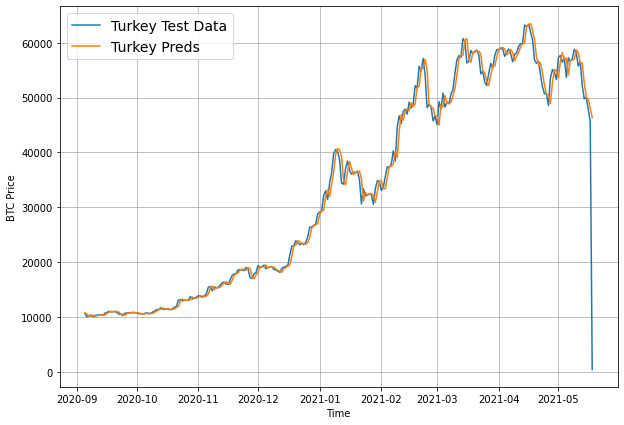

In [223]:
plt.figure(figsize=(10,7))
offset=300
plot_time_series(
    timesteps=btc_timesteps_turkey[-len(X_test):],
    values=btc_price_turkey[-len(y_test):],
    format="-",
    label="Turkey Test Data",
    start=offset)

plot_time_series(
    timesteps=btc_timesteps_turkey[-len(X_test):],
    values=turkey_preds,
    format="-",
    label="Turkey Preds",
    start=offset)